In [1]:
#!/usr/bin/env python3
# ============================================================================
# PFSCN DUAL-ATTRIBUTE MILP MODEL - COMPLETE SINGLE FILE
# ============================================================================
# Perishable Food Supply Chain Network Optimization
# With Dual Quality Attributes (Firmness & Color), Wang & Li Pricing,
# Facility Opening Costs, and Comprehensive Results Analysis
#
# Author: Damilola (Texas A&M University-Kingsville)
# Date: December 2025
#
# Features:
# - Arrhenius kinetics pre-computation (MINLP → MILP)
# - Dual quality tracking (Firmness + Color)
# - Wang & Li quality-based pricing tiers
# - Facility opening costs (Suppliers, Warehouses)
# - McCormick linearization for bilinear terms
# - Comprehensive results extraction
# ============================================================================

import pyomo.environ as pyo
from pyomo.opt import SolverFactory, TerminationCondition
import math
import time
from datetime import datetime

# ============================================================================
# CONSTANTS
# ============================================================================
R_GAS = 8.314  # Universal gas constant (J/mol·K)
M_QUALITY = 100.0  # Big-M for quality bounds
M_FLOW = 1000.0  # Big-M for flow bounds

# Temperature options (Kelvin)
TEMP_REFRIGERATED = 277.15  # 4°C
TEMP_AMBIENT = 293.15  # 20°C

# Phase durations (hours)
TAU_INBOUND = 2.3  # Supplier → Warehouse
TAU_STORAGE = 24.0  # Per period (1 day)

# DISTANCE-DEPENDENT OUTBOUND TRANSPORT TIMES (hours)
# Different retailers are at different distances from warehouses
TAU_OUTBOUND = {
    ('W1', 'R1'): 1.0,   # R1 is closer to W1 (1 hour)
    ('W1', 'R2'): 2.5,   # R2 is farther from W1 (2.5 hours)
    ('W2', 'R1'): 2.0,   # R1 is farther from W2 (2 hours)
    ('W2', 'R2'): 1.2,   # R2 is closer to W2 (1.2 hours)
}


def print_header():
    """Print model header"""
    print("\n" + "=" * 80)
    print("🍅 PERISHABLE FOOD SUPPLY CHAIN NETWORK - DUAL ATTRIBUTE MILP")
    print("   Firmness & Color Quality Tracking with Wang & Li Pricing")
    print("   WITH FACILITY OPENING COSTS")
    print("=" * 80)
    print(f"Start Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print("=" * 80)


def print_section(title, char="="):
    """Print section header"""
    print(f"\n{char * 80}")
    print(f"  {title}")
    print(f"{char * 80}")


# ============================================================================
# PHASE 1: ARRHENIUS PRE-COMPUTATION
# ============================================================================
def compute_arrhenius_k(A, Ea, T):
    """Compute degradation rate constant: k = A × exp(-Ea/RT)"""
    return A * math.exp(-Ea / (R_GAS * T))


def compute_retention(k, tau):
    """Compute quality retention: ρ = exp(-k × τ)"""
    return math.exp(-k * tau)


def precompute_arrhenius_parameters():
    """
    Pre-compute all Arrhenius degradation rates and retention factors.
    This converts the MINLP to MILP by making k values parameters.
    Now includes DISTANCE-DEPENDENT outbound transport times.
    """
    print_section("PHASE 1: ARRHENIUS PARAMETER PRE-COMPUTATION")
    
    print(f"\n📐 Phase Durations:")
    print(f"   Inbound transport:  {TAU_INBOUND} hours")
    print(f"   Storage per period: {TAU_STORAGE} hours (1 day)")
    print(f"\n   Outbound transport (DISTANCE-DEPENDENT):")
    for (w, r), tau in TAU_OUTBOUND.items():
        print(f"      {w}→{r}: {tau} hours")
    
    # FIRMNESS parameters (Van Dijk et al. 2006)
    Ea_firmness = 50000  # J/mol (50 kJ/mol)
    A_firmness = 2.5e6   # 1/hour
    
    k_firm_refrig = compute_arrhenius_k(A_firmness, Ea_firmness, TEMP_REFRIGERATED)
    k_firm_ambient = compute_arrhenius_k(A_firmness, Ea_firmness, TEMP_AMBIENT)
    
    print(f"\n🔬 FIRMNESS Degradation Parameters:")
    print(f"   Activation Energy (Ea): {Ea_firmness/1000:.1f} kJ/mol")
    print(f"   Pre-exponential (A):    {A_firmness:.2e} /hour")
    print(f"   Rate at 4°C:   k = {k_firm_refrig:.6f} /hour ({k_firm_refrig*24:.4f} /day)")
    print(f"   Rate at 20°C:  k = {k_firm_ambient:.6f} /hour ({k_firm_ambient*24:.4f} /day)")
    print(f"   Temperature sensitivity: {k_firm_ambient/k_firm_refrig:.2f}× faster at ambient")
    
    # COLOR/LYCOPENE parameters (Badin et al. 2021)
    Ea_color = 25000  # J/mol (25 kJ/mol)
    A_color = 3.5e1   # 1/hour
    
    k_color_refrig = compute_arrhenius_k(A_color, Ea_color, TEMP_REFRIGERATED)
    k_color_ambient = compute_arrhenius_k(A_color, Ea_color, TEMP_AMBIENT)
    
    print(f"\n🎨 COLOR/LYCOPENE Degradation Parameters:")
    print(f"   Activation Energy (Ea): {Ea_color/1000:.1f} kJ/mol")
    print(f"   Pre-exponential (A):    {A_color:.2e} /hour")
    print(f"   Rate at 4°C:   k = {k_color_refrig:.6f} /hour ({k_color_refrig*24:.4f} /day)")
    print(f"   Rate at 20°C:  k = {k_color_ambient:.6f} /hour ({k_color_ambient*24:.4f} /day)")
    print(f"   Temperature sensitivity: {k_color_ambient/k_color_refrig:.2f}× faster at ambient")
    
    # Compute retention factors for inbound and storage (same as before)
    print(f"\n📊 Pre-computing retention factors (exp(-k×τ))...")
    
    retention = {
        'firmness': {
            ('Refrigerated', 'inbound'): compute_retention(k_firm_refrig, TAU_INBOUND),
            ('Refrigerated', 'storage'): compute_retention(k_firm_refrig, TAU_STORAGE),
            ('Ambient', 'inbound'): compute_retention(k_firm_ambient, TAU_INBOUND),
            ('Ambient', 'storage'): compute_retention(k_firm_ambient, TAU_STORAGE),
        },
        'color': {
            ('Refrigerated', 'inbound'): compute_retention(k_color_refrig, TAU_INBOUND),
            ('Refrigerated', 'storage'): compute_retention(k_color_refrig, TAU_STORAGE),
            ('Ambient', 'inbound'): compute_retention(k_color_ambient, TAU_INBOUND),
            ('Ambient', 'storage'): compute_retention(k_color_ambient, TAU_STORAGE),
        }
    }
    
    # Compute DISTANCE-DEPENDENT outbound retention factors
    for (w, r), tau in TAU_OUTBOUND.items():
        retention['firmness'][('Refrigerated', 'outbound', w, r)] = compute_retention(k_firm_refrig, tau)
        retention['firmness'][('Ambient', 'outbound', w, r)] = compute_retention(k_firm_ambient, tau)
        retention['color'][('Refrigerated', 'outbound', w, r)] = compute_retention(k_color_refrig, tau)
        retention['color'][('Ambient', 'outbound', w, r)] = compute_retention(k_color_ambient, tau)
    
    # Print retention tables
    for attr in ['firmness', 'color']:
        print(f"\n   {attr.upper()} Retention by Phase:")
        print(f"   {'Phase':<20} {'Refrigerated':>12} {'Ambient':>12} {'Δ Loss':>10}")
        print(f"   {'-'*54}")
        for phase in ['inbound', 'storage']:
            rho_ref = retention[attr][('Refrigerated', phase)] * 100
            rho_amb = retention[attr][('Ambient', phase)] * 100
            delta = rho_ref - rho_amb
            print(f"   {phase.capitalize():<20} {rho_ref:>11.2f}% {rho_amb:>11.2f}% {delta:>+9.2f}%")
    
    # Print distance-dependent outbound retention
    print(f"\n   OUTBOUND Retention (DISTANCE-DEPENDENT):")
    print(f"   {'Route':<12} {'Time(h)':<8} {'Firm-Ref':>10} {'Firm-Amb':>10} {'Color-Ref':>10} {'Color-Amb':>10}")
    print(f"   {'-'*70}")
    for (w, r), tau in TAU_OUTBOUND.items():
        firm_ref = retention['firmness'][('Refrigerated', 'outbound', w, r)] * 100
        firm_amb = retention['firmness'][('Ambient', 'outbound', w, r)] * 100
        color_ref = retention['color'][('Refrigerated', 'outbound', w, r)] * 100
        color_amb = retention['color'][('Ambient', 'outbound', w, r)] * 100
        print(f"   {w}→{r:<8} {tau:<8.1f} {firm_ref:>9.2f}% {firm_amb:>9.2f}% {color_ref:>9.2f}% {color_amb:>9.2f}%")
    
    print(f"\n✅ Arrhenius parameters pre-computed successfully!")
    
    return retention


# ============================================================================
# PHASE 2: BUILD PYOMO MODEL
# ============================================================================
def build_model(retention):
    """Build the complete Pyomo MILP model"""
    
    print_section("PHASE 2: BUILDING PYOMO MILP MODEL")
    
    model = pyo.ConcreteModel(name="PFSCN_DualAttribute_MILP_WithFacilityCosts")
    
    # =========================================================================
    # [1/10] SETS
    # =========================================================================
    print("\n[1/10] Defining sets...")
    
    model.P = pyo.Set(initialize=['Tomatoes'], doc="Products")
    model.B = pyo.Set(initialize=['B1'], doc="Batches")
    model.S = pyo.Set(initialize=['S1', 'S2'], doc="Suppliers")  # Multiple suppliers
    model.W = pyo.Set(initialize=['W1', 'W2'], doc="Warehouses")  # Multiple warehouses
    model.R = pyo.Set(initialize=['R1', 'R2'], doc="Retailers")
    model.V = pyo.Set(initialize=['Refrigerated', 'Ambient'], doc="Vehicle/storage types")
    model.T = pyo.RangeSet(0, 10, doc="Time periods (days)")
    
    print(f"   ✓ Products: {list(model.P)}")
    print(f"   ✓ Suppliers: {list(model.S)}")
    print(f"   ✓ Warehouses: {list(model.W)}")
    print(f"   ✓ Retailers: {list(model.R)}")
    print(f"   ✓ Vehicle types: {list(model.V)}")
    print(f"   ✓ Time periods: {list(model.T)} ({len(list(model.T))} days)")
    
    # =========================================================================
    # [2/10] ARRHENIUS RETENTION PARAMETERS
    # =========================================================================
    print("\n[2/10] Loading pre-computed retention parameters...")
    
    # Firmness retention
    model.rho_firmness_inbound = pyo.Param(model.V, initialize={
        'Refrigerated': retention['firmness'][('Refrigerated', 'inbound')],
        'Ambient': retention['firmness'][('Ambient', 'inbound')]
    })
    model.rho_firmness_storage = pyo.Param(model.V, initialize={
        'Refrigerated': retention['firmness'][('Refrigerated', 'storage')],
        'Ambient': retention['firmness'][('Ambient', 'storage')]
    })
    
    # Color retention
    model.rho_color_inbound = pyo.Param(model.V, initialize={
        'Refrigerated': retention['color'][('Refrigerated', 'inbound')],
        'Ambient': retention['color'][('Ambient', 'inbound')]
    })
    model.rho_color_storage = pyo.Param(model.V, initialize={
        'Refrigerated': retention['color'][('Refrigerated', 'storage')],
        'Ambient': retention['color'][('Ambient', 'storage')]
    })
    
    # DISTANCE-DEPENDENT outbound retention (indexed by vehicle, warehouse, retailer)
    model.rho_firmness_outbound = pyo.Param(model.V, model.W, model.R, initialize={
        ('Refrigerated', w, r): retention['firmness'][('Refrigerated', 'outbound', w, r)]
        for w in ['W1', 'W2'] for r in ['R1', 'R2']
    } | {
        ('Ambient', w, r): retention['firmness'][('Ambient', 'outbound', w, r)]
        for w in ['W1', 'W2'] for r in ['R1', 'R2']
    })
    
    model.rho_color_outbound = pyo.Param(model.V, model.W, model.R, initialize={
        ('Refrigerated', w, r): retention['color'][('Refrigerated', 'outbound', w, r)]
        for w in ['W1', 'W2'] for r in ['R1', 'R2']
    } | {
        ('Ambient', w, r): retention['color'][('Ambient', 'outbound', w, r)]
        for w in ['W1', 'W2'] for r in ['R1', 'R2']
    })
    
    # Quality weights
    model.w_firmness = pyo.Param(initialize=0.6, doc="Firmness weight")
    model.w_color = pyo.Param(initialize=0.4, doc="Color weight")
    
    print(f"   ✓ Firmness retention: inbound, storage, outbound (distance-dependent)")
    print(f"   ✓ Color retention: inbound, storage, outbound (distance-dependent)")
    print(f"   ✓ Outbound times: W1→R1={TAU_OUTBOUND[('W1','R1')]}h, W1→R2={TAU_OUTBOUND[('W1','R2')]}h")
    print(f"   ✓ Composite = {model.w_firmness.value*100:.0f}% Firmness + {model.w_color.value*100:.0f}% Color")
    
    # =========================================================================
    # [3/10] FACILITY OPENING COSTS (NEW!)
    # =========================================================================
    print("\n[3/10] Setting facility opening costs...")
    
    # Supplier opening/contracting costs (annual fixed cost)
    model.f_supplier = pyo.Param(model.S, initialize={
        'S1': 500.0,   # Primary supplier - lower fixed cost
        'S2': 800.0,   # Secondary supplier - higher fixed cost
    }, doc="Fixed cost to use supplier ($/planning horizon)")
    
    # Warehouse opening costs (depends on refrigeration capability)
    model.f_warehouse = pyo.Param(model.W, initialize={
        'W1': 1000.0,  # Standard warehouse
        'W2': 1500.0,  # Premium location warehouse
    }, doc="Fixed cost to open warehouse ($/planning horizon)")
    
    # Additional cost for refrigerated storage capability
    model.f_refrigeration = pyo.Param(model.W, initialize={
        'W1': 300.0,   # Refrigeration upgrade cost
        'W2': 400.0,
    }, doc="Fixed cost for refrigeration capability ($/planning horizon)")
    
    print(f"   ✓ Supplier fixed costs: S1=${model.f_supplier['S1']}, S2=${model.f_supplier['S2']}")
    print(f"   ✓ Warehouse fixed costs: W1=${model.f_warehouse['W1']}, W2=${model.f_warehouse['W2']}")
    print(f"   ✓ Refrigeration upgrade: W1=${model.f_refrigeration['W1']}, W2=${model.f_refrigeration['W2']}")
    
    # =========================================================================
    # [4/10] VARIABLE COSTS
    # =========================================================================
    print("\n[4/10] Setting variable cost parameters...")
    
    model.c_purchase = pyo.Param(model.S, initialize={
        'S1': 2.00,  # Primary supplier
        'S2': 2.20,  # Secondary supplier (higher unit cost)
    }, doc="Purchase cost ($/kg)")
    
    model.c_vehicle = pyo.Param(model.V, initialize={
        'Refrigerated': 1.50,
        'Ambient': 0.50
    }, doc="Transport cost ($/kg)")
    
    model.c_storage = pyo.Param(model.V, initialize={
        'Refrigerated': 0.80,
        'Ambient': 0.30
    }, doc="Storage cost ($/kg/day)")
    
    model.c_waste = pyo.Param(initialize=3.0, doc="Waste disposal cost ($/kg)")
    model.c_penalty = pyo.Param(initialize=50.0, doc="Unmet demand penalty ($/kg)")
    
    print(f"   ✓ Purchase: S1=${model.c_purchase['S1']}/kg, S2=${model.c_purchase['S2']}/kg")
    print(f"   ✓ Transport: Refrig=${model.c_vehicle['Refrigerated']}/kg, Ambient=${model.c_vehicle['Ambient']}/kg")
    print(f"   ✓ Storage: Refrig=${model.c_storage['Refrigerated']}/kg/day, Ambient=${model.c_storage['Ambient']}/kg/day")
    print(f"   ✓ Waste disposal: ${model.c_waste.value}/kg")
    print(f"   ✓ Unmet demand penalty: ${model.c_penalty.value}/kg")
    
    # =========================================================================
    # [5/10] WANG & LI PRICING
    # =========================================================================
    print("\n[5/10] Setting Wang & Li quality-based pricing tiers...")
    
    model.Q_premium_min = pyo.Param(initialize=90.0)
    model.Q_standard_min = pyo.Param(initialize=75.0)
    model.Q_discount_min = pyo.Param(initialize=60.0)
    
    model.p_premium = pyo.Param(model.R, initialize={'R1': 12.00, 'R2': 14.00})
    model.p_standard = pyo.Param(model.R, initialize={'R1': 8.50, 'R2': 10.00})
    model.p_discount = pyo.Param(model.R, initialize={'R1': 5.00, 'R2': 6.00})
    
    print(f"   ✓ Premium tier (Q ≥ 90%):  R1=${model.p_premium['R1']}, R2=${model.p_premium['R2']}")
    print(f"   ✓ Standard tier (Q ≥ 75%): R1=${model.p_standard['R1']}, R2=${model.p_standard['R2']}")
    print(f"   ✓ Discount tier (Q ≥ 60%): R1=${model.p_discount['R1']}, R2=${model.p_discount['R2']}")
    print(f"   ✓ Waste tier (Q < 60%):    No revenue, disposal cost applies")
    
    # =========================================================================
    # [6/10] DEMAND PARAMETERS
    # =========================================================================
    print("\n[6/10] Setting fluctuating demand pattern...")
    
    demand_data = {}
    # Weekly pattern for each retailer
    base_demand = {
        'R1': [80, 100, 120, 150, 140, 90, 70, 80, 100, 120, 150],
        'R2': [100, 120, 140, 180, 170, 110, 90, 100, 120, 140, 180]
    }
    for r in ['R1', 'R2']:
        for t in range(11):
            demand_data[('Tomatoes', r, 'B1', t)] = base_demand[r][t]
    
    model.D = pyo.Param(model.P, model.R, model.B, model.T, initialize=demand_data)
    
    total_demand = sum(demand_data.values())
    print(f"   ✓ R1 demand range: {min(base_demand['R1'])}-{max(base_demand['R1'])} kg/day")
    print(f"   ✓ R2 demand range: {min(base_demand['R2'])}-{max(base_demand['R2'])} kg/day")
    print(f"   ✓ Total demand over horizon: {total_demand} kg")
    
    # =========================================================================
    # [7/10] CAPACITY PARAMETERS
    # =========================================================================
    print("\n[7/10] Setting capacity parameters...")
    
    model.cap_supplier = pyo.Param(model.S, initialize={
        'S1': 400,
        'S2': 300,
    }, doc="Supplier capacity (kg/day)")
    
    model.cap_warehouse = pyo.Param(model.W, initialize={
        'W1': 500,
        'W2': 400,
    }, doc="Warehouse capacity (kg)")
    
    print(f"   ✓ Supplier capacity: S1={model.cap_supplier['S1']} kg/day, S2={model.cap_supplier['S2']} kg/day")
    print(f"   ✓ Warehouse capacity: W1={model.cap_warehouse['W1']} kg, W2={model.cap_warehouse['W2']} kg")
    
    # =========================================================================
    # [8/10] DECISION VARIABLES
    # =========================================================================
    print("\n[8/10] Defining decision variables...")
    
    # FACILITY OPENING BINARIES (NEW!)
    model.y_supplier = pyo.Var(model.S, domain=pyo.Binary, 
                                doc="1 if supplier s is used")
    model.y_warehouse = pyo.Var(model.W, domain=pyo.Binary,
                                 doc="1 if warehouse w is opened")
    model.y_refrig_capability = pyo.Var(model.W, domain=pyo.Binary,
                                         doc="1 if warehouse w has refrigeration")
    
    # Vehicle selection binaries
    model.y_inbound = pyo.Var(model.V, model.P, model.B, model.S, model.W, model.T,
                               domain=pyo.Binary, doc="Inbound vehicle selection")
    model.y_storage = pyo.Var(model.V, model.P, model.B, model.W, model.T,
                               domain=pyo.Binary, doc="Storage type selection")
    model.y_outbound = pyo.Var(model.V, model.P, model.B, model.W, model.R, model.T,
                                domain=pyo.Binary, doc="Outbound vehicle selection")
    
    # Flow variables
    model.X_purchase = pyo.Var(model.P, model.B, model.S, model.T,
                                domain=pyo.NonNegativeReals, doc="Purchase quantity")
    model.X_SW = pyo.Var(model.P, model.B, model.S, model.W, model.T,
                          domain=pyo.NonNegativeReals, doc="Supplier→Warehouse flow")
    model.X_WR = pyo.Var(model.P, model.B, model.W, model.R, model.T,
                          domain=pyo.NonNegativeReals, doc="Warehouse→Retailer flow")
    
    # Inventory
    model.I = pyo.Var(model.P, model.B, model.W, model.T,
                       domain=pyo.NonNegativeReals, bounds=(0, 600), doc="Inventory")
    
    # Quality variables
    model.Q_firmness_inv = pyo.Var(model.P, model.B, model.W, model.T, bounds=(0, 100))
    model.Q_color_inv = pyo.Var(model.P, model.B, model.W, model.T, bounds=(0, 100))
    model.Q_firmness_del = pyo.Var(model.P, model.B, model.W, model.R, model.T, bounds=(0, 100))
    model.Q_color_del = pyo.Var(model.P, model.B, model.W, model.R, model.T, bounds=(0, 100))
    model.Q_composite = pyo.Var(model.P, model.B, model.W, model.R, model.T, bounds=(0, 100))
    
    # Zone classification
    model.phi_premium = pyo.Var(model.P, model.B, model.W, model.R, model.T, domain=pyo.Binary)
    model.phi_standard = pyo.Var(model.P, model.B, model.W, model.R, model.T, domain=pyo.Binary)
    model.phi_discount = pyo.Var(model.P, model.B, model.W, model.R, model.T, domain=pyo.Binary)
    model.phi_waste = pyo.Var(model.P, model.B, model.W, model.R, model.T, domain=pyo.Binary)
    
    # Sales by tier
    model.S_premium = pyo.Var(model.P, model.B, model.W, model.R, model.T, domain=pyo.NonNegativeReals)
    model.S_standard = pyo.Var(model.P, model.B, model.W, model.R, model.T, domain=pyo.NonNegativeReals)
    model.S_discount = pyo.Var(model.P, model.B, model.W, model.R, model.T, domain=pyo.NonNegativeReals)
    
    # Waste and shortage
    model.W_waste = pyo.Var(model.P, model.B, model.W, model.R, model.T, domain=pyo.NonNegativeReals)
    model.U = pyo.Var(model.P, model.R, model.B, model.T, domain=pyo.NonNegativeReals)
    
    # McCormick auxiliary variables
    model.Q_firm_aux = pyo.Var(model.V, model.P, model.B, model.W, model.T, bounds=(0, 100))
    model.Q_color_aux = pyo.Var(model.V, model.P, model.B, model.W, model.T, bounds=(0, 100))
    
    print(f"   ✓ Facility opening binaries (suppliers, warehouses, refrigeration)")
    print(f"   ✓ Vehicle selection binaries (per-period flexibility)")
    print(f"   ✓ Flow variables: purchase, S→W, W→R")
    print(f"   ✓ Inventory variables")
    print(f"   ✓ Dual quality: Firmness + Color (inventory & delivery)")
    print(f"   ✓ Zone classification: Premium/Standard/Discount/Waste")
    print(f"   ✓ Sales by tier + Waste + Unmet demand")
    print(f"   ✓ McCormick auxiliary variables")
    
    # =========================================================================
    # [9/10] CONSTRAINTS
    # =========================================================================
    print("\n[9/10] Adding constraints...")
    
    # --- FACILITY OPENING CONSTRAINTS ---
    
    # Flow only if supplier is open
    def supplier_open_rule(m, p, b, s, t):
        return m.X_purchase[p, b, s, t] <= m.cap_supplier[s] * m.y_supplier[s]
    model.c_supplier_open = pyo.Constraint(model.P, model.B, model.S, model.T, rule=supplier_open_rule)
    
    # Flow only if warehouse is open
    def warehouse_open_inflow_rule(m, p, b, s, w, t):
        return m.X_SW[p, b, s, w, t] <= M_FLOW * m.y_warehouse[w]
    model.c_warehouse_open_in = pyo.Constraint(model.P, model.B, model.S, model.W, model.T, 
                                                rule=warehouse_open_inflow_rule)
    
    def warehouse_open_outflow_rule(m, p, b, w, r, t):
        return m.X_WR[p, b, w, r, t] <= M_FLOW * m.y_warehouse[w]
    model.c_warehouse_open_out = pyo.Constraint(model.P, model.B, model.W, model.R, model.T,
                                                 rule=warehouse_open_outflow_rule)
    
    # Refrigerated storage only if capability is installed
    def refrig_capability_rule(m, p, b, w, t):
        return m.y_storage['Refrigerated', p, b, w, t] <= m.y_refrig_capability[w]
    model.c_refrig_cap = pyo.Constraint(model.P, model.B, model.W, model.T, rule=refrig_capability_rule)
    
    # Refrigeration capability requires warehouse to be open
    def refrig_requires_warehouse_rule(m, w):
        return m.y_refrig_capability[w] <= m.y_warehouse[w]
    model.c_refrig_req = pyo.Constraint(model.W, rule=refrig_requires_warehouse_rule)
    
    print(f"   ✓ Facility opening constraints (supplier, warehouse, refrigeration)")
    
    # --- VEHICLE SELECTION CONSTRAINTS ---
    
    def one_inbound_rule(m, p, b, s, w, t):
        return sum(m.y_inbound[v, p, b, s, w, t] for v in m.V) == m.y_warehouse[w]
    model.c_one_inbound = pyo.Constraint(model.P, model.B, model.S, model.W, model.T, rule=one_inbound_rule)
    
    def one_storage_rule(m, p, b, w, t):
        return sum(m.y_storage[v, p, b, w, t] for v in m.V) == m.y_warehouse[w]
    model.c_one_storage = pyo.Constraint(model.P, model.B, model.W, model.T, rule=one_storage_rule)
    
    def one_outbound_rule(m, p, b, w, r, t):
        return sum(m.y_outbound[v, p, b, w, r, t] for v in m.V) == m.y_warehouse[w]
    model.c_one_outbound = pyo.Constraint(model.P, model.B, model.W, model.R, model.T, rule=one_outbound_rule)
    
    print(f"   ✓ Vehicle selection constraints")
    
    # --- FLOW BALANCE CONSTRAINTS ---
    
    def supplier_balance_rule(m, p, b, s, t):
        return m.X_purchase[p, b, s, t] == sum(m.X_SW[p, b, s, w, t] for w in m.W)
    model.c_supplier_balance = pyo.Constraint(model.P, model.B, model.S, model.T, rule=supplier_balance_rule)
    
    def inventory_balance_rule(m, p, b, w, t):
        if t == 0:
            return m.I[p, b, w, t] == 0
        inflow = sum(m.X_SW[p, b, s, w, t-1] for s in m.S)
        outflow = sum(m.X_WR[p, b, w, r, t-1] for r in m.R)
        return m.I[p, b, w, t] == m.I[p, b, w, t-1] + inflow - outflow
    model.c_inventory_balance = pyo.Constraint(model.P, model.B, model.W, model.T, rule=inventory_balance_rule)
    
    def warehouse_capacity_rule(m, p, b, w, t):
        inflow = sum(m.X_SW[p, b, s, w, t] for s in m.S)
        return m.I[p, b, w, t] + inflow <= m.cap_warehouse[w]
    model.c_warehouse_cap = pyo.Constraint(model.P, model.B, model.W, model.T, rule=warehouse_capacity_rule)
    
    print(f"   ✓ Flow balance constraints")
    
    # --- McCORMICK CONSTRAINTS ---
    
    # Firmness McCormick
    def mc_firm_lb1(m, v, p, b, w, t):
        return m.Q_firm_aux[v, p, b, w, t] >= 0
    model.c_mc_f1 = pyo.Constraint(model.V, model.P, model.B, model.W, model.T, rule=mc_firm_lb1)
    
    def mc_firm_lb2(m, v, p, b, w, t):
        if t == 0:
            return pyo.Constraint.Skip
        return m.Q_firm_aux[v, p, b, w, t] >= m.Q_firmness_inv[p, b, w, t-1] - M_QUALITY * (1 - m.y_storage[v, p, b, w, t-1])
    model.c_mc_f2 = pyo.Constraint(model.V, model.P, model.B, model.W, model.T, rule=mc_firm_lb2)
    
    def mc_firm_ub1(m, v, p, b, w, t):
        if t == 0:
            return pyo.Constraint.Skip
        return m.Q_firm_aux[v, p, b, w, t] <= m.Q_firmness_inv[p, b, w, t-1]
    model.c_mc_f3 = pyo.Constraint(model.V, model.P, model.B, model.W, model.T, rule=mc_firm_ub1)
    
    def mc_firm_ub2(m, v, p, b, w, t):
        return m.Q_firm_aux[v, p, b, w, t] <= M_QUALITY * m.y_storage[v, p, b, w, t]
    model.c_mc_f4 = pyo.Constraint(model.V, model.P, model.B, model.W, model.T, rule=mc_firm_ub2)
    
    # Color McCormick (same structure)
    def mc_color_lb1(m, v, p, b, w, t):
        return m.Q_color_aux[v, p, b, w, t] >= 0
    model.c_mc_c1 = pyo.Constraint(model.V, model.P, model.B, model.W, model.T, rule=mc_color_lb1)
    
    def mc_color_lb2(m, v, p, b, w, t):
        if t == 0:
            return pyo.Constraint.Skip
        return m.Q_color_aux[v, p, b, w, t] >= m.Q_color_inv[p, b, w, t-1] - M_QUALITY * (1 - m.y_storage[v, p, b, w, t-1])
    model.c_mc_c2 = pyo.Constraint(model.V, model.P, model.B, model.W, model.T, rule=mc_color_lb2)
    
    def mc_color_ub1(m, v, p, b, w, t):
        if t == 0:
            return pyo.Constraint.Skip
        return m.Q_color_aux[v, p, b, w, t] <= m.Q_color_inv[p, b, w, t-1]
    model.c_mc_c3 = pyo.Constraint(model.V, model.P, model.B, model.W, model.T, rule=mc_color_ub1)
    
    def mc_color_ub2(m, v, p, b, w, t):
        return m.Q_color_aux[v, p, b, w, t] <= M_QUALITY * m.y_storage[v, p, b, w, t]
    model.c_mc_c4 = pyo.Constraint(model.V, model.P, model.B, model.W, model.T, rule=mc_color_ub2)
    
    print(f"   ✓ McCormick linearization constraints")
    
    # --- QUALITY EVOLUTION CONSTRAINTS ---
    
    # Initial quality (after inbound)
    def firmness_init_rule(m, p, b, w, t):
        if t == 0:
            return m.Q_firmness_inv[p, b, w, t] == 100.0 * sum(
                m.rho_firmness_inbound[v] * sum(m.y_inbound[v, p, b, s, w, t] for s in m.S) / max(len(list(m.S)), 1)
                for v in m.V
            )
        return pyo.Constraint.Skip
    model.c_firm_init = pyo.Constraint(model.P, model.B, model.W, model.T, rule=firmness_init_rule)
    
    # Quality evolution through storage
    def firmness_evol_rule(m, p, b, w, t):
        if t == 0:
            return pyo.Constraint.Skip
        return m.Q_firmness_inv[p, b, w, t] == sum(
            m.rho_firmness_storage[v] * m.Q_firm_aux[v, p, b, w, t]
            for v in m.V
        )
    model.c_firm_evol = pyo.Constraint(model.P, model.B, model.W, model.T, rule=firmness_evol_rule)
    
    # Quality at delivery (NOW DISTANCE-DEPENDENT)
    def firmness_del_rule(m, p, b, w, r, t):
        # Average outbound retention for this specific warehouse-retailer pair
        avg_rho = (m.rho_firmness_outbound['Refrigerated', w, r] + m.rho_firmness_outbound['Ambient', w, r]) / 2
        return m.Q_firmness_del[p, b, w, r, t] == m.Q_firmness_inv[p, b, w, t] * avg_rho
    model.c_firm_del = pyo.Constraint(model.P, model.B, model.W, model.R, model.T, rule=firmness_del_rule)
    
    # Color evolution (same structure)
    def color_init_rule(m, p, b, w, t):
        if t == 0:
            return m.Q_color_inv[p, b, w, t] == 100.0 * sum(
                m.rho_color_inbound[v] * sum(m.y_inbound[v, p, b, s, w, t] for s in m.S) / max(len(list(m.S)), 1)
                for v in m.V
            )
        return pyo.Constraint.Skip
    model.c_color_init = pyo.Constraint(model.P, model.B, model.W, model.T, rule=color_init_rule)
    
    def color_evol_rule(m, p, b, w, t):
        if t == 0:
            return pyo.Constraint.Skip
        return m.Q_color_inv[p, b, w, t] == sum(
            m.rho_color_storage[v] * m.Q_color_aux[v, p, b, w, t]
            for v in m.V
        )
    model.c_color_evol = pyo.Constraint(model.P, model.B, model.W, model.T, rule=color_evol_rule)
    
    def color_del_rule(m, p, b, w, r, t):
        # Average outbound retention for this specific warehouse-retailer pair
        avg_rho = (m.rho_color_outbound['Refrigerated', w, r] + m.rho_color_outbound['Ambient', w, r]) / 2
        return m.Q_color_del[p, b, w, r, t] == m.Q_color_inv[p, b, w, t] * avg_rho
    model.c_color_del = pyo.Constraint(model.P, model.B, model.W, model.R, model.T, rule=color_del_rule)
    
    # Composite quality
    def composite_rule(m, p, b, w, r, t):
        return m.Q_composite[p, b, w, r, t] == (
            m.w_firmness * m.Q_firmness_del[p, b, w, r, t] +
            m.w_color * m.Q_color_del[p, b, w, r, t]
        )
    model.c_composite = pyo.Constraint(model.P, model.B, model.W, model.R, model.T, rule=composite_rule)
    
    print(f"   ✓ Quality evolution constraints (Firmness + Color)")
    
    # --- ZONE CLASSIFICATION CONSTRAINTS ---
    
    def zone_exclusive_rule(m, p, b, w, r, t):
        return (m.phi_premium[p,b,w,r,t] + m.phi_standard[p,b,w,r,t] + 
                m.phi_discount[p,b,w,r,t] + m.phi_waste[p,b,w,r,t]) == 1
    model.c_zone_excl = pyo.Constraint(model.P, model.B, model.W, model.R, model.T, rule=zone_exclusive_rule)
    
    # Premium: Q >= 90
    def premium_lb_rule(m, p, b, w, r, t):
        return m.Q_composite[p,b,w,r,t] >= m.Q_premium_min - M_QUALITY * (1 - m.phi_premium[p,b,w,r,t])
    model.c_prem_lb = pyo.Constraint(model.P, model.B, model.W, model.R, model.T, rule=premium_lb_rule)
    
    # Standard: 75 <= Q < 90
    def standard_lb_rule(m, p, b, w, r, t):
        return m.Q_composite[p,b,w,r,t] >= m.Q_standard_min - M_QUALITY * (1 - m.phi_standard[p,b,w,r,t])
    model.c_std_lb = pyo.Constraint(model.P, model.B, model.W, model.R, model.T, rule=standard_lb_rule)
    
    def standard_ub_rule(m, p, b, w, r, t):
        return m.Q_composite[p,b,w,r,t] <= m.Q_premium_min + M_QUALITY * (1 - m.phi_standard[p,b,w,r,t])
    model.c_std_ub = pyo.Constraint(model.P, model.B, model.W, model.R, model.T, rule=standard_ub_rule)
    
    # Discount: 60 <= Q < 75
    def discount_lb_rule(m, p, b, w, r, t):
        return m.Q_composite[p,b,w,r,t] >= m.Q_discount_min - M_QUALITY * (1 - m.phi_discount[p,b,w,r,t])
    model.c_disc_lb = pyo.Constraint(model.P, model.B, model.W, model.R, model.T, rule=discount_lb_rule)
    
    def discount_ub_rule(m, p, b, w, r, t):
        return m.Q_composite[p,b,w,r,t] <= m.Q_standard_min + M_QUALITY * (1 - m.phi_discount[p,b,w,r,t])
    model.c_disc_ub = pyo.Constraint(model.P, model.B, model.W, model.R, model.T, rule=discount_ub_rule)
    
    # Waste: Q < 60
    def waste_ub_rule(m, p, b, w, r, t):
        return m.Q_composite[p,b,w,r,t] <= m.Q_discount_min + M_QUALITY * (1 - m.phi_waste[p,b,w,r,t])
    model.c_waste_ub = pyo.Constraint(model.P, model.B, model.W, model.R, model.T, rule=waste_ub_rule)
    
    print(f"   ✓ Quality zone classification (Big-M)")
    
    # --- SALES LINEARIZATION ---
    
    # Premium sales
    def prem_ub_rule(m, p, b, w, r, t):
        return m.S_premium[p,b,w,r,t] <= m.X_WR[p,b,w,r,t]
    model.c_prem_ub = pyo.Constraint(model.P, model.B, model.W, model.R, model.T, rule=prem_ub_rule)
    
    def prem_link_rule(m, p, b, w, r, t):
        return m.S_premium[p,b,w,r,t] <= M_FLOW * m.phi_premium[p,b,w,r,t]
    model.c_prem_link = pyo.Constraint(model.P, model.B, model.W, model.R, model.T, rule=prem_link_rule)
    
    def prem_lb_rule(m, p, b, w, r, t):
        return m.S_premium[p,b,w,r,t] >= m.X_WR[p,b,w,r,t] - M_FLOW * (1 - m.phi_premium[p,b,w,r,t])
    model.c_prem_lb2 = pyo.Constraint(model.P, model.B, model.W, model.R, model.T, rule=prem_lb_rule)
    
    # Standard sales
    def std_ub_rule(m, p, b, w, r, t):
        return m.S_standard[p,b,w,r,t] <= m.X_WR[p,b,w,r,t]
    model.c_std_ub2 = pyo.Constraint(model.P, model.B, model.W, model.R, model.T, rule=std_ub_rule)
    
    def std_link_rule(m, p, b, w, r, t):
        return m.S_standard[p,b,w,r,t] <= M_FLOW * m.phi_standard[p,b,w,r,t]
    model.c_std_link = pyo.Constraint(model.P, model.B, model.W, model.R, model.T, rule=std_link_rule)
    
    def std_lb_rule(m, p, b, w, r, t):
        return m.S_standard[p,b,w,r,t] >= m.X_WR[p,b,w,r,t] - M_FLOW * (1 - m.phi_standard[p,b,w,r,t])
    model.c_std_lb2 = pyo.Constraint(model.P, model.B, model.W, model.R, model.T, rule=std_lb_rule)
    
    # Discount sales
    def disc_ub_rule(m, p, b, w, r, t):
        return m.S_discount[p,b,w,r,t] <= m.X_WR[p,b,w,r,t]
    model.c_disc_ub2 = pyo.Constraint(model.P, model.B, model.W, model.R, model.T, rule=disc_ub_rule)
    
    def disc_link_rule(m, p, b, w, r, t):
        return m.S_discount[p,b,w,r,t] <= M_FLOW * m.phi_discount[p,b,w,r,t]
    model.c_disc_link = pyo.Constraint(model.P, model.B, model.W, model.R, model.T, rule=disc_link_rule)
    
    def disc_lb_rule(m, p, b, w, r, t):
        return m.S_discount[p,b,w,r,t] >= m.X_WR[p,b,w,r,t] - M_FLOW * (1 - m.phi_discount[p,b,w,r,t])
    model.c_disc_lb2 = pyo.Constraint(model.P, model.B, model.W, model.R, model.T, rule=disc_lb_rule)
    
    # Waste linkage
    def waste_link_rule(m, p, b, w, r, t):
        return m.W_waste[p,b,w,r,t] >= m.X_WR[p,b,w,r,t] - M_FLOW * (1 - m.phi_waste[p,b,w,r,t])
    model.c_waste_link = pyo.Constraint(model.P, model.B, model.W, model.R, model.T, rule=waste_link_rule)
    
    print(f"   ✓ Sales linearization by tier")
    
    # --- DEMAND SATISFACTION ---
    
    def demand_rule(m, p, r, b, t):
        total_sales = sum(
            m.S_premium[p,b,w,r,t] + m.S_standard[p,b,w,r,t] + m.S_discount[p,b,w,r,t]
            for w in m.W
        )
        return total_sales + m.U[p,r,b,t] == m.D[p,r,b,t]
    model.c_demand = pyo.Constraint(model.P, model.R, model.B, model.T, rule=demand_rule)
    
    print(f"   ✓ Demand satisfaction")
    
    # =========================================================================
    # [10/10] OBJECTIVE FUNCTION
    # =========================================================================
    print("\n[10/10] Setting objective function...")
    
    def profit_rule(m):
        # REVENUE
        revenue = sum(
            m.p_premium[r] * m.S_premium[p,b,w,r,t] +
            m.p_standard[r] * m.S_standard[p,b,w,r,t] +
            m.p_discount[r] * m.S_discount[p,b,w,r,t]
            for p in m.P for b in m.B for w in m.W for r in m.R for t in m.T
        )
        
        # FIXED COSTS (FACILITY OPENING)
        supplier_fixed = sum(m.f_supplier[s] * m.y_supplier[s] for s in m.S)
        warehouse_fixed = sum(m.f_warehouse[w] * m.y_warehouse[w] for w in m.W)
        refrigeration_fixed = sum(m.f_refrigeration[w] * m.y_refrig_capability[w] for w in m.W)
        
        # VARIABLE COSTS
        # Purchase cost (by supplier)
        purchase_cost = sum(
            m.c_purchase[s] * m.X_purchase[p,b,s,t]
            for p in m.P for b in m.B for s in m.S for t in m.T
        )
        
        # Transport cost (using average for linearization)
        avg_transport = (m.c_vehicle['Refrigerated'] + m.c_vehicle['Ambient']) / 2
        transport_cost = sum(
            avg_transport * (m.X_SW[p,b,s,w,t] + sum(m.X_WR[p,b,w,r,t] for r in m.R))
            for p in m.P for b in m.B for s in m.S for w in m.W for t in m.T
        )
        
        # Storage cost
        avg_storage = (m.c_storage['Refrigerated'] + m.c_storage['Ambient']) / 2
        storage_cost = sum(
            avg_storage * m.I[p,b,w,t]
            for p in m.P for b in m.B for w in m.W for t in m.T
        )
        
        # Waste cost
        waste_cost = sum(
            m.c_waste * m.W_waste[p,b,w,r,t]
            for p in m.P for b in m.B for w in m.W for r in m.R for t in m.T
        )
        
        # Penalty cost
        penalty_cost = sum(
            m.c_penalty * m.U[p,r,b,t]
            for p in m.P for r in m.R for b in m.B for t in m.T
        )
        
        total_fixed = supplier_fixed + warehouse_fixed + refrigeration_fixed
        total_variable = purchase_cost + transport_cost + storage_cost + waste_cost + penalty_cost
        
        return revenue - total_fixed - total_variable
    
    model.profit = pyo.Objective(rule=profit_rule, sense=pyo.maximize)
    
    print(f"   ✓ Maximize: Revenue - Fixed Costs - Variable Costs")
    print(f"   ✓ Fixed Costs: Supplier + Warehouse + Refrigeration")
    print(f"   ✓ Variable Costs: Purchase + Transport + Storage + Waste + Penalty")
    
    return model


# ============================================================================
# PHASE 3: SOLVE MODEL
# ============================================================================
def solve_model(model):
    """Solve with best available solver (Gurobi preferred)"""
    
    print_section("PHASE 3: SOLVING MILP")
    
    # Detect solver
    solvers = ['gurobi', 'cplex', 'cbc', 'glpk']
    solver_name = None
    
    for s in solvers:
        solver = SolverFactory(s)
        if solver.available():
            solver_name = s
            print(f"🔧 Using solver: {s.upper()}")
            break
    
    if not solver_name:
        print("❌ No solver available!")
        return None
    
    solver = SolverFactory(solver_name)
    
    # Solver options
    if solver_name == 'gurobi':
        solver.options['MIPGap'] = 0.01
        solver.options['TimeLimit'] = 300
        solver.options['Threads'] = 0
    elif solver_name == 'cbc':
        solver.options['ratio'] = 0.01
        solver.options['sec'] = 300
    
    # Solve
    start_time = time.time()
    results = solver.solve(model, tee=True)
    solve_time = time.time() - start_time
    
    print(f"\n⏱️ Solve time: {solve_time:.2f} seconds")
    
    return results, solve_time


# ============================================================================
# PHASE 4: COMPREHENSIVE RESULTS ANALYSIS
# ============================================================================
def analyze_results(model):
    """Extract and display comprehensive results"""
    
    print_section("PHASE 4: COMPREHENSIVE RESULTS ANALYSIS", "═")
    
    # =========================================================================
    # 4.1 FACILITY OPENING DECISIONS
    # =========================================================================
    print("\n" + "─" * 80)
    print("  4.1 FACILITY OPENING DECISIONS")
    print("─" * 80)
    
    print("\n🏭 SUPPLIERS:")
    print(f"   {'Supplier':<10} {'Status':<12} {'Fixed Cost':<12} {'Unit Cost':<12}")
    print(f"   {'-'*46}")
    total_supplier_fixed = 0
    for s in model.S:
        status = "✅ OPEN" if pyo.value(model.y_supplier[s]) > 0.5 else "❌ CLOSED"
        fixed = model.f_supplier[s] if pyo.value(model.y_supplier[s]) > 0.5 else 0
        total_supplier_fixed += fixed
        print(f"   {s:<10} {status:<12} ${model.f_supplier[s]:<11.2f} ${model.c_purchase[s]:<11.2f}/kg")
    print(f"   {'-'*46}")
    print(f"   {'Total Fixed Cost:':<22} ${total_supplier_fixed:.2f}")
    
    print("\n🏢 WAREHOUSES:")
    print(f"   {'Warehouse':<10} {'Status':<12} {'Fixed Cost':<12} {'Capacity':<12} {'Refrigeration':<15}")
    print(f"   {'-'*61}")
    total_warehouse_fixed = 0
    total_refrig_fixed = 0
    for w in model.W:
        status = "✅ OPEN" if pyo.value(model.y_warehouse[w]) > 0.5 else "❌ CLOSED"
        refrig = "❄️ YES" if pyo.value(model.y_refrig_capability[w]) > 0.5 else "🌡️ NO"
        fixed_w = model.f_warehouse[w] if pyo.value(model.y_warehouse[w]) > 0.5 else 0
        fixed_r = model.f_refrigeration[w] if pyo.value(model.y_refrig_capability[w]) > 0.5 else 0
        total_warehouse_fixed += fixed_w
        total_refrig_fixed += fixed_r
        print(f"   {w:<10} {status:<12} ${model.f_warehouse[w]:<11.2f} {model.cap_warehouse[w]:<12} kg {refrig:<15}")
    print(f"   {'-'*61}")
    print(f"   {'Warehouse Fixed Cost:':<22} ${total_warehouse_fixed:.2f}")
    print(f"   {'Refrigeration Fixed Cost:':<22} ${total_refrig_fixed:.2f}")
    
    total_fixed_costs = total_supplier_fixed + total_warehouse_fixed + total_refrig_fixed
    print(f"\n   📊 TOTAL FIXED COSTS: ${total_fixed_costs:,.2f}")
    
    # =========================================================================
    # 4.2 TRANSPORTATION DECISIONS
    # =========================================================================
    print("\n" + "─" * 80)
    print("  4.2 TRANSPORTATION DECISIONS")
    print("─" * 80)
    
    print("\n📦 INBOUND TRANSPORT (Supplier → Warehouse):")
    print(f"   {'Day':<6} {'Route':<15} {'Vehicle':<15} {'Quantity (kg)':<15}")
    print(f"   {'-'*51}")
    inbound_refrig = 0
    inbound_ambient = 0
    for t in model.T:
        for s in model.S:
            for w in model.W:
                qty = sum(pyo.value(model.X_SW[p, 'B1', s, w, t]) for p in model.P)
                if qty > 0.01:
                    for v in model.V:
                        if pyo.value(model.y_inbound[v, 'Tomatoes', 'B1', s, w, t]) > 0.5:
                            icon = "❄️" if v == 'Refrigerated' else "🌡️"
                            print(f"   {t:<6} {s}→{w:<12} {icon} {v:<12} {qty:<15.1f}")
                            if v == 'Refrigerated':
                                inbound_refrig += 1
                            else:
                                inbound_ambient += 1
    print(f"   {'-'*51}")
    print(f"   Summary: Refrigerated={inbound_refrig}, Ambient={inbound_ambient}")
    
    print("\n🏭 STORAGE DECISIONS:")
    print(f"   {'Day':<6} {'Warehouse':<12} {'Storage Type':<15}")
    print(f"   {'-'*33}")
    storage_refrig = 0
    storage_ambient = 0
    for t in model.T:
        for w in model.W:
            if pyo.value(model.y_warehouse[w]) > 0.5:
                for v in model.V:
                    if pyo.value(model.y_storage[v, 'Tomatoes', 'B1', w, t]) > 0.5:
                        icon = "❄️" if v == 'Refrigerated' else "🌡️"
                        print(f"   {t:<6} {w:<12} {icon} {v:<12}")
                        if v == 'Refrigerated':
                            storage_refrig += 1
                        else:
                            storage_ambient += 1
    print(f"   {'-'*33}")
    print(f"   Summary: Refrigerated={storage_refrig}, Ambient={storage_ambient}")
    
    print("\n🚚 OUTBOUND TRANSPORT (Warehouse → Retailer):")
    print(f"   {'Day':<6} {'Route':<15} {'Vehicle':<15} {'Quantity (kg)':<15}")
    print(f"   {'-'*51}")
    outbound_refrig = 0
    outbound_ambient = 0
    for t in model.T:
        for w in model.W:
            for r in model.R:
                qty = sum(pyo.value(model.X_WR[p, 'B1', w, r, t]) for p in model.P)
                if qty > 0.01:
                    for v in model.V:
                        if pyo.value(model.y_outbound[v, 'Tomatoes', 'B1', w, r, t]) > 0.5:
                            icon = "❄️" if v == 'Refrigerated' else "🌡️"
                            print(f"   {t:<6} {w}→{r:<12} {icon} {v:<12} {qty:<15.1f}")
                            if v == 'Refrigerated':
                                outbound_refrig += 1
                            else:
                                outbound_ambient += 1
    print(f"   {'-'*51}")
    print(f"   Summary: Refrigerated={outbound_refrig}, Ambient={outbound_ambient}")
    
    # =========================================================================
    # 4.3 PRODUCT FLOWS
    # =========================================================================
    print("\n" + "─" * 80)
    print("  4.3 PRODUCT FLOWS")
    print("─" * 80)
    
    print("\n💵 PURCHASES BY SUPPLIER:")
    print(f"   {'Day':<6} {'Supplier':<10} {'Quantity (kg)':<15} {'Unit Cost':<12} {'Total Cost':<12}")
    print(f"   {'-'*55}")
    total_purchase_cost = 0
    purchase_by_supplier = {s: 0 for s in model.S}
    for t in model.T:
        for s in model.S:
            qty = sum(pyo.value(model.X_purchase[p, 'B1', s, t]) for p in model.P)
            if qty > 0.01:
                cost = qty * model.c_purchase[s]
                total_purchase_cost += cost
                purchase_by_supplier[s] += qty
                print(f"   {t:<6} {s:<10} {qty:<15.1f} ${model.c_purchase[s]:<11.2f} ${cost:<11.2f}")
    print(f"   {'-'*55}")
    print(f"   TOTAL PURCHASE COST: ${total_purchase_cost:,.2f}")
    for s in model.S:
        if purchase_by_supplier[s] > 0:
            print(f"   {s} total: {purchase_by_supplier[s]:.1f} kg")
    
    print("\n📤 DELIVERIES TO RETAILERS:")
    print(f"   {'Day':<6} {'Route':<15} {'Delivered (kg)':<15} {'Demand (kg)':<15} {'Fill %':<10}")
    print(f"   {'-'*61}")
    total_delivered = {r: 0 for r in model.R}
    total_demand = {r: 0 for r in model.R}
    for t in model.T:
        for r in model.R:
            demand = model.D['Tomatoes', r, 'B1', t]
            total_demand[r] += demand
            for w in model.W:
                qty = pyo.value(model.X_WR['Tomatoes', 'B1', w, r, t])
                if qty > 0.01:
                    fill = qty / demand * 100 if demand > 0 else 0
                    total_delivered[r] += qty
                    print(f"   {t:<6} {w}→{r:<12} {qty:<15.1f} {demand:<15.0f} {fill:<10.1f}%")
    print(f"   {'-'*61}")
    for r in model.R:
        fill = total_delivered[r] / total_demand[r] * 100 if total_demand[r] > 0 else 0
        print(f"   {r}: Delivered={total_delivered[r]:.0f} kg, Demand={total_demand[r]:.0f} kg, Fill={fill:.1f}%")
    
    # =========================================================================
    # 4.4 INVENTORY ANALYSIS
    # =========================================================================
    print("\n" + "─" * 80)
    print("  4.4 INVENTORY ANALYSIS")
    print("─" * 80)
    
    print(f"\n   {'Day':<6} {'Warehouse':<10} {'Start Inv':<12} {'+ Inflow':<12} {'- Outflow':<12} {'End Inv':<12}")
    print(f"   {'-'*64}")
    for t in model.T:
        for w in model.W:
            if pyo.value(model.y_warehouse[w]) > 0.5:
                inv = pyo.value(model.I['Tomatoes', 'B1', w, t])
                inflow = sum(pyo.value(model.X_SW['Tomatoes', 'B1', s, w, t]) for s in model.S)
                outflow = sum(pyo.value(model.X_WR['Tomatoes', 'B1', w, r, t]) for r in model.R)
                end_inv = inv + inflow - outflow
                print(f"   {t:<6} {w:<10} {inv:<12.1f} {inflow:<12.1f} {outflow:<12.1f} {end_inv:<12.1f}")
    
    # =========================================================================
    # 4.5 DETAILED COST BREAKDOWN
    # =========================================================================
    print("\n" + "─" * 80)
    print("  4.5 DETAILED COST BREAKDOWN")
    print("─" * 80)
    
    # Fixed costs (already calculated)
    
    # Variable transport costs (actual, not linearized)
    inbound_cost_refrig = 0
    inbound_cost_ambient = 0
    outbound_cost_refrig = 0
    outbound_cost_ambient = 0
    
    for t in model.T:
        for s in model.S:
            for w in model.W:
                qty = pyo.value(model.X_SW['Tomatoes', 'B1', s, w, t])
                if qty > 0.01:
                    for v in model.V:
                        if pyo.value(model.y_inbound[v, 'Tomatoes', 'B1', s, w, t]) > 0.5:
                            if v == 'Refrigerated':
                                inbound_cost_refrig += qty * model.c_vehicle[v]
                            else:
                                inbound_cost_ambient += qty * model.c_vehicle[v]
        for w in model.W:
            for r in model.R:
                qty = pyo.value(model.X_WR['Tomatoes', 'B1', w, r, t])
                if qty > 0.01:
                    for v in model.V:
                        if pyo.value(model.y_outbound[v, 'Tomatoes', 'B1', w, r, t]) > 0.5:
                            if v == 'Refrigerated':
                                outbound_cost_refrig += qty * model.c_vehicle[v]
                            else:
                                outbound_cost_ambient += qty * model.c_vehicle[v]
    
    total_transport = inbound_cost_refrig + inbound_cost_ambient + outbound_cost_refrig + outbound_cost_ambient
    
    # Storage costs
    storage_cost_refrig = 0
    storage_cost_ambient = 0
    for t in model.T:
        for w in model.W:
            inv = pyo.value(model.I['Tomatoes', 'B1', w, t])
            inflow = sum(pyo.value(model.X_SW['Tomatoes', 'B1', s, w, t]) for s in model.S)
            stored = inv + inflow
            for v in model.V:
                if pyo.value(model.y_storage[v, 'Tomatoes', 'B1', w, t]) > 0.5:
                    if v == 'Refrigerated':
                        storage_cost_refrig += stored * model.c_storage[v]
                    else:
                        storage_cost_ambient += stored * model.c_storage[v]
    
    total_storage = storage_cost_refrig + storage_cost_ambient
    
    # Waste and penalty
    total_waste_qty = sum(pyo.value(model.W_waste[p, b, w, r, t]) 
                          for p in model.P for b in model.B for w in model.W for r in model.R for t in model.T)
    waste_cost = total_waste_qty * model.c_waste.value
    
    total_unmet_qty = sum(pyo.value(model.U[p, r, b, t])
                          for p in model.P for r in model.R for b in model.B for t in model.T)
    penalty_cost = total_unmet_qty * model.c_penalty.value
    
    total_variable = total_purchase_cost + total_transport + total_storage + waste_cost + penalty_cost
    total_costs = total_fixed_costs + total_variable
    
    print(f"\n   {'COST CATEGORY':<35} {'AMOUNT ($)':<15} {'% OF TOTAL':<12}")
    print(f"   {'═'*62}")
    print(f"   {'FIXED COSTS':<35}")
    print(f"   {'  Supplier Opening':<35} ${total_supplier_fixed:>12,.2f} {total_supplier_fixed/total_costs*100:>10.1f}%")
    print(f"   {'  Warehouse Opening':<35} ${total_warehouse_fixed:>12,.2f} {total_warehouse_fixed/total_costs*100:>10.1f}%")
    print(f"   {'  Refrigeration Capability':<35} ${total_refrig_fixed:>12,.2f} {total_refrig_fixed/total_costs*100:>10.1f}%")
    print(f"   {'  ─ Subtotal Fixed':<35} ${total_fixed_costs:>12,.2f} {total_fixed_costs/total_costs*100:>10.1f}%")
    print(f"   {'─'*62}")
    print(f"   {'VARIABLE COSTS':<35}")
    print(f"   {'  Purchase Cost':<35} ${total_purchase_cost:>12,.2f} {total_purchase_cost/total_costs*100:>10.1f}%")
    print(f"   {'  Transport - Inbound Refrig':<35} ${inbound_cost_refrig:>12,.2f}")
    print(f"   {'  Transport - Inbound Ambient':<35} ${inbound_cost_ambient:>12,.2f}")
    print(f"   {'  Transport - Outbound Refrig':<35} ${outbound_cost_refrig:>12,.2f}")
    print(f"   {'  Transport - Outbound Ambient':<35} ${outbound_cost_ambient:>12,.2f}")
    print(f"   {'  ─ Subtotal Transport':<35} ${total_transport:>12,.2f} {total_transport/total_costs*100:>10.1f}%")
    print(f"   {'  Storage - Refrigerated':<35} ${storage_cost_refrig:>12,.2f}")
    print(f"   {'  Storage - Ambient':<35} ${storage_cost_ambient:>12,.2f}")
    print(f"   {'  ─ Subtotal Storage':<35} ${total_storage:>12,.2f} {total_storage/total_costs*100:>10.1f}%")
    print(f"   {'  Waste Disposal':<35} ${waste_cost:>12,.2f} {waste_cost/total_costs*100:>10.1f}%")
    print(f"   {'  Unmet Demand Penalty':<35} ${penalty_cost:>12,.2f} {penalty_cost/total_costs*100:>10.1f}%")
    print(f"   {'  ─ Subtotal Variable':<35} ${total_variable:>12,.2f} {total_variable/total_costs*100:>10.1f}%")
    print(f"   {'═'*62}")
    print(f"   {'TOTAL COSTS':<35} ${total_costs:>12,.2f} {'100.0%':>12}")
    
    # =========================================================================
    # 4.6 REVENUE BREAKDOWN
    # =========================================================================
    print("\n" + "─" * 80)
    print("  4.6 REVENUE BREAKDOWN BY RETAILER AND TIER")
    print("─" * 80)
    
    revenue_data = {}
    for r in model.R:
        revenue_data[r] = {'Premium': 0, 'Standard': 0, 'Discount': 0, 'qty_prem': 0, 'qty_std': 0, 'qty_disc': 0}
        
        print(f"\n   📊 RETAILER {r}:")
        print(f"   {'Day':<6} {'Premium(kg)':<12} {'Standard(kg)':<12} {'Discount(kg)':<12} {'Revenue($)':<12}")
        print(f"   {'-'*54}")
        
        for t in model.T:
            prem_qty = sum(pyo.value(model.S_premium['Tomatoes', 'B1', w, r, t]) for w in model.W)
            std_qty = sum(pyo.value(model.S_standard['Tomatoes', 'B1', w, r, t]) for w in model.W)
            disc_qty = sum(pyo.value(model.S_discount['Tomatoes', 'B1', w, r, t]) for w in model.W)
            
            rev = (prem_qty * model.p_premium[r] + std_qty * model.p_standard[r] + disc_qty * model.p_discount[r])
            
            revenue_data[r]['qty_prem'] += prem_qty
            revenue_data[r]['qty_std'] += std_qty
            revenue_data[r]['qty_disc'] += disc_qty
            revenue_data[r]['Premium'] += prem_qty * model.p_premium[r]
            revenue_data[r]['Standard'] += std_qty * model.p_standard[r]
            revenue_data[r]['Discount'] += disc_qty * model.p_discount[r]
            
            if prem_qty > 0.01 or std_qty > 0.01 or disc_qty > 0.01:
                print(f"   {t:<6} {prem_qty:<12.1f} {std_qty:<12.1f} {disc_qty:<12.1f} ${rev:<11.2f}")
        
        total_r = revenue_data[r]['Premium'] + revenue_data[r]['Standard'] + revenue_data[r]['Discount']
        print(f"   {'-'*54}")
        print(f"   {'TOTAL':<6} {revenue_data[r]['qty_prem']:<12.1f} {revenue_data[r]['qty_std']:<12.1f} "
              f"{revenue_data[r]['qty_disc']:<12.1f} ${total_r:<11.2f}")
    
    total_revenue = sum(revenue_data[r]['Premium'] + revenue_data[r]['Standard'] + revenue_data[r]['Discount'] 
                        for r in model.R)
    
    print(f"\n   {'─'*62}")
    print(f"   REVENUE SUMMARY:")
    print(f"   {'Retailer':<10} {'Premium($)':<15} {'Standard($)':<15} {'Discount($)':<15} {'Total($)':<15}")
    print(f"   {'-'*70}")
    for r in model.R:
        total_r = revenue_data[r]['Premium'] + revenue_data[r]['Standard'] + revenue_data[r]['Discount']
        print(f"   {r:<10} ${revenue_data[r]['Premium']:<14,.2f} ${revenue_data[r]['Standard']:<14,.2f} "
              f"${revenue_data[r]['Discount']:<14,.2f} ${total_r:<14,.2f}")
    print(f"   {'-'*70}")
    print(f"   {'TOTAL':<10} ${sum(revenue_data[r]['Premium'] for r in model.R):<14,.2f} "
          f"${sum(revenue_data[r]['Standard'] for r in model.R):<14,.2f} "
          f"${sum(revenue_data[r]['Discount'] for r in model.R):<14,.2f} "
          f"${total_revenue:<14,.2f}")
    
    # =========================================================================
    # 4.7 QUALITY EVOLUTION
    # =========================================================================
    print("\n" + "─" * 80)
    print("  4.7 QUALITY EVOLUTION BY RETAILER")
    print("─" * 80)
    
    for r in model.R:
        print(f"\n   🍅 RETAILER {r}:")
        print(f"   {'Day':<6} {'Firmness':<12} {'Color':<12} {'Composite':<12} {'Tier':<12}")
        print(f"   {'-'*54}")
        for t in model.T:
            for w in model.W:
                if pyo.value(model.y_warehouse[w]) > 0.5:
                    firm = pyo.value(model.Q_firmness_del['Tomatoes', 'B1', w, r, t])
                    color = pyo.value(model.Q_color_del['Tomatoes', 'B1', w, r, t])
                    comp = pyo.value(model.Q_composite['Tomatoes', 'B1', w, r, t])
                    
                    if comp >= 90:
                        tier = "🟢 Premium"
                    elif comp >= 75:
                        tier = "🟡 Standard"
                    elif comp >= 60:
                        tier = "🟠 Discount"
                    else:
                        tier = "🔴 Waste"
                    
                    print(f"   {t:<6} {firm:<11.1f}% {color:<11.1f}% {comp:<11.1f}% {tier}")
                    break  # Only show one warehouse
    
    # =========================================================================
    # 4.8 PROFIT SUMMARY
    # =========================================================================
    print("\n" + "─" * 80)
    print("  4.8 PROFIT SUMMARY")
    print("─" * 80)
    
    profit = pyo.value(model.profit)
    margin = profit / total_revenue * 100 if total_revenue > 0 else 0
    total_qty = sum(revenue_data[r]['qty_prem'] + revenue_data[r]['qty_std'] + revenue_data[r]['qty_disc'] 
                    for r in model.R)
    
    print(f"""
   ┌─────────────────────────────────────────────────────────────────┐
   │                    FINANCIAL SUMMARY                            │
   ├─────────────────────────────────────────────────────────────────┤
   │  💰 Total Revenue:         ${total_revenue:>12,.2f}                     │
   │  📉 Total Fixed Costs:     ${total_fixed_costs:>12,.2f}                     │
   │  📉 Total Variable Costs:  ${total_variable:>12,.2f}                     │
   │  ─────────────────────────────────────────────────────────────  │
   │  💵 NET PROFIT:            ${profit:>12,.2f}                     │
   │  📊 Profit Margin:         {margin:>12.1f}%                    │
   ├─────────────────────────────────────────────────────────────────┤
   │  Per-Unit Economics (per kg):                                   │
   │    Average selling price:  ${total_revenue/max(total_qty,1):>12.2f}                     │
   │    Average cost:           ${total_costs/max(total_qty,1):>12.2f}                     │
   │    Average profit:         ${profit/max(total_qty,1):>12.2f}                     │
   └─────────────────────────────────────────────────────────────────┘
    """)
    
    return {
        'profit': profit,
        'revenue': total_revenue,
        'fixed_costs': total_fixed_costs,
        'variable_costs': total_variable,
        'total_costs': total_costs
    }


# ============================================================================
# MAIN EXECUTION
# ============================================================================
def main():
    """Main execution function"""
    
    print_header()
    
    # Phase 1: Arrhenius pre-computation
    retention = precompute_arrhenius_parameters()
    
    # Phase 2: Build model
    model = build_model(retention)
    
    # Phase 3: Solve
    results, solve_time = solve_model(model)
    
    if results.solver.termination_condition in [TerminationCondition.optimal, TerminationCondition.feasible]:
        # Phase 4: Analysis
        summary = analyze_results(model)
        
        print_section("OPTIMIZATION COMPLETE", "═")
        print(f"End Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        print(f"Status: ✅ {'OPTIMAL' if results.solver.termination_condition == TerminationCondition.optimal else 'FEASIBLE'}")
        print(f"Solve Time: {solve_time:.2f} seconds")
        print(f"Final Profit: ${summary['profit']:,.2f}")
    else:
        print(f"\n❌ Optimization failed: {results.solver.termination_condition}")
    
    return model


if __name__ == "__main__":
    model = main()


🍅 PERISHABLE FOOD SUPPLY CHAIN NETWORK - DUAL ATTRIBUTE MILP
   Firmness & Color Quality Tracking with Wang & Li Pricing
   WITH FACILITY OPENING COSTS
Start Time: 2025-12-28 14:52:14

  PHASE 1: ARRHENIUS PARAMETER PRE-COMPUTATION

📐 Phase Durations:
   Inbound transport:  2.3 hours
   Storage per period: 24.0 hours (1 day)

   Outbound transport (DISTANCE-DEPENDENT):
      W1→R1: 1.0 hours
      W1→R2: 2.5 hours
      W2→R1: 2.0 hours
      W2→R2: 1.2 hours

🔬 FIRMNESS Degradation Parameters:
   Activation Energy (Ea): 50.0 kJ/mol
   Pre-exponential (A):    2.50e+06 /hour
   Rate at 4°C:   k = 0.000942 /hour (0.0226 /day)
   Rate at 20°C:  k = 0.003079 /hour (0.0739 /day)
   Temperature sensitivity: 3.27× faster at ambient

🎨 COLOR/LYCOPENE Degradation Parameters:
   Activation Energy (Ea): 25.0 kJ/mol
   Pre-exponential (A):    3.50e+01 /hour
   Rate at 4°C:   k = 0.000679 /hour (0.0163 /day)
   Rate at 20°C:  k = 0.001228 /hour (0.0295 /day)
   Temperature sensitivity: 1.81× faste


📊 PFSCN VISUALIZATION SUITE (Distance-Dependent)
Generating publication-ready figures...

✅ Saved: pfscn_quality_comparison.png


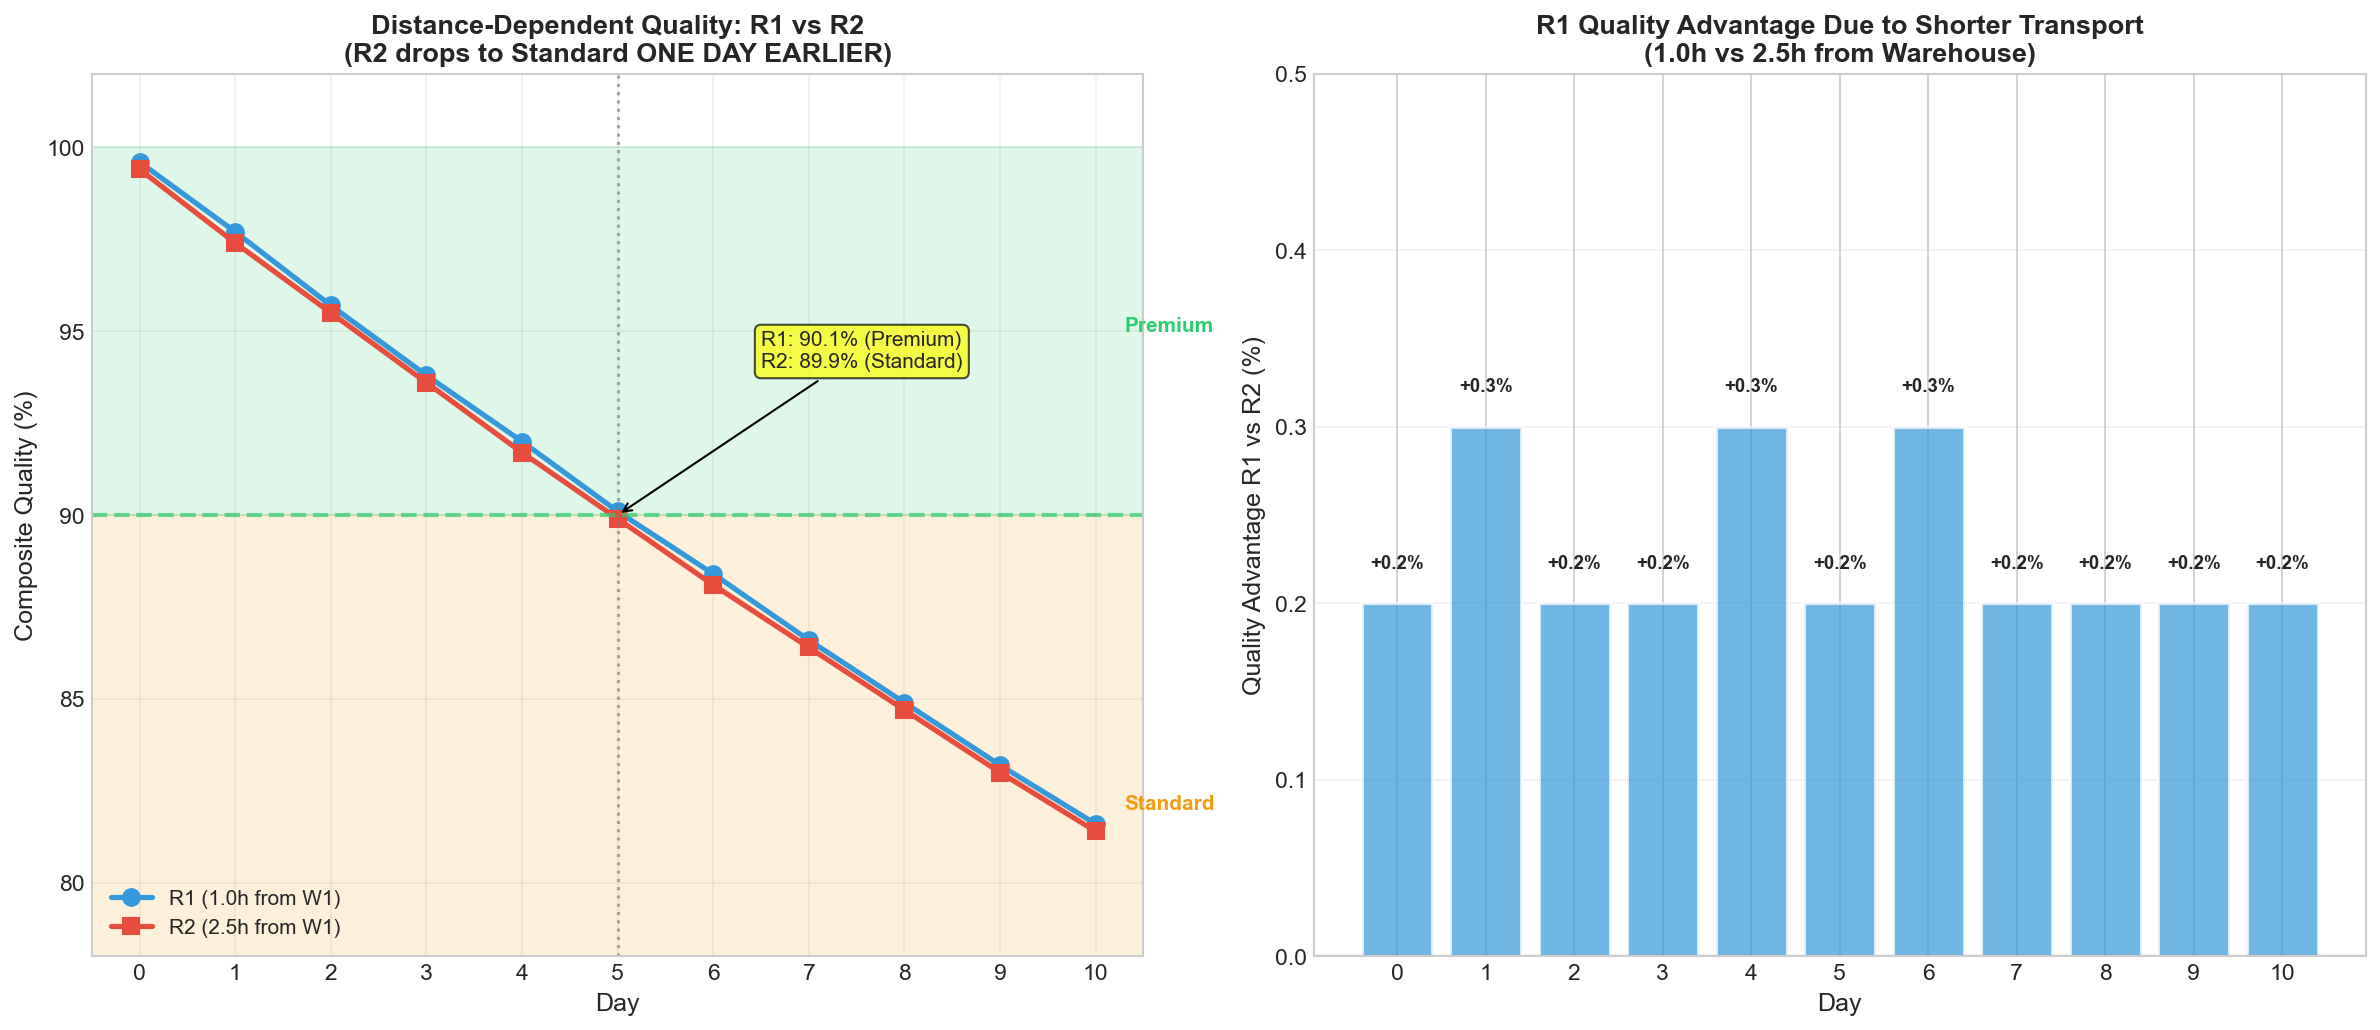

✅ Saved: pfscn_quality_dual_attribute.png


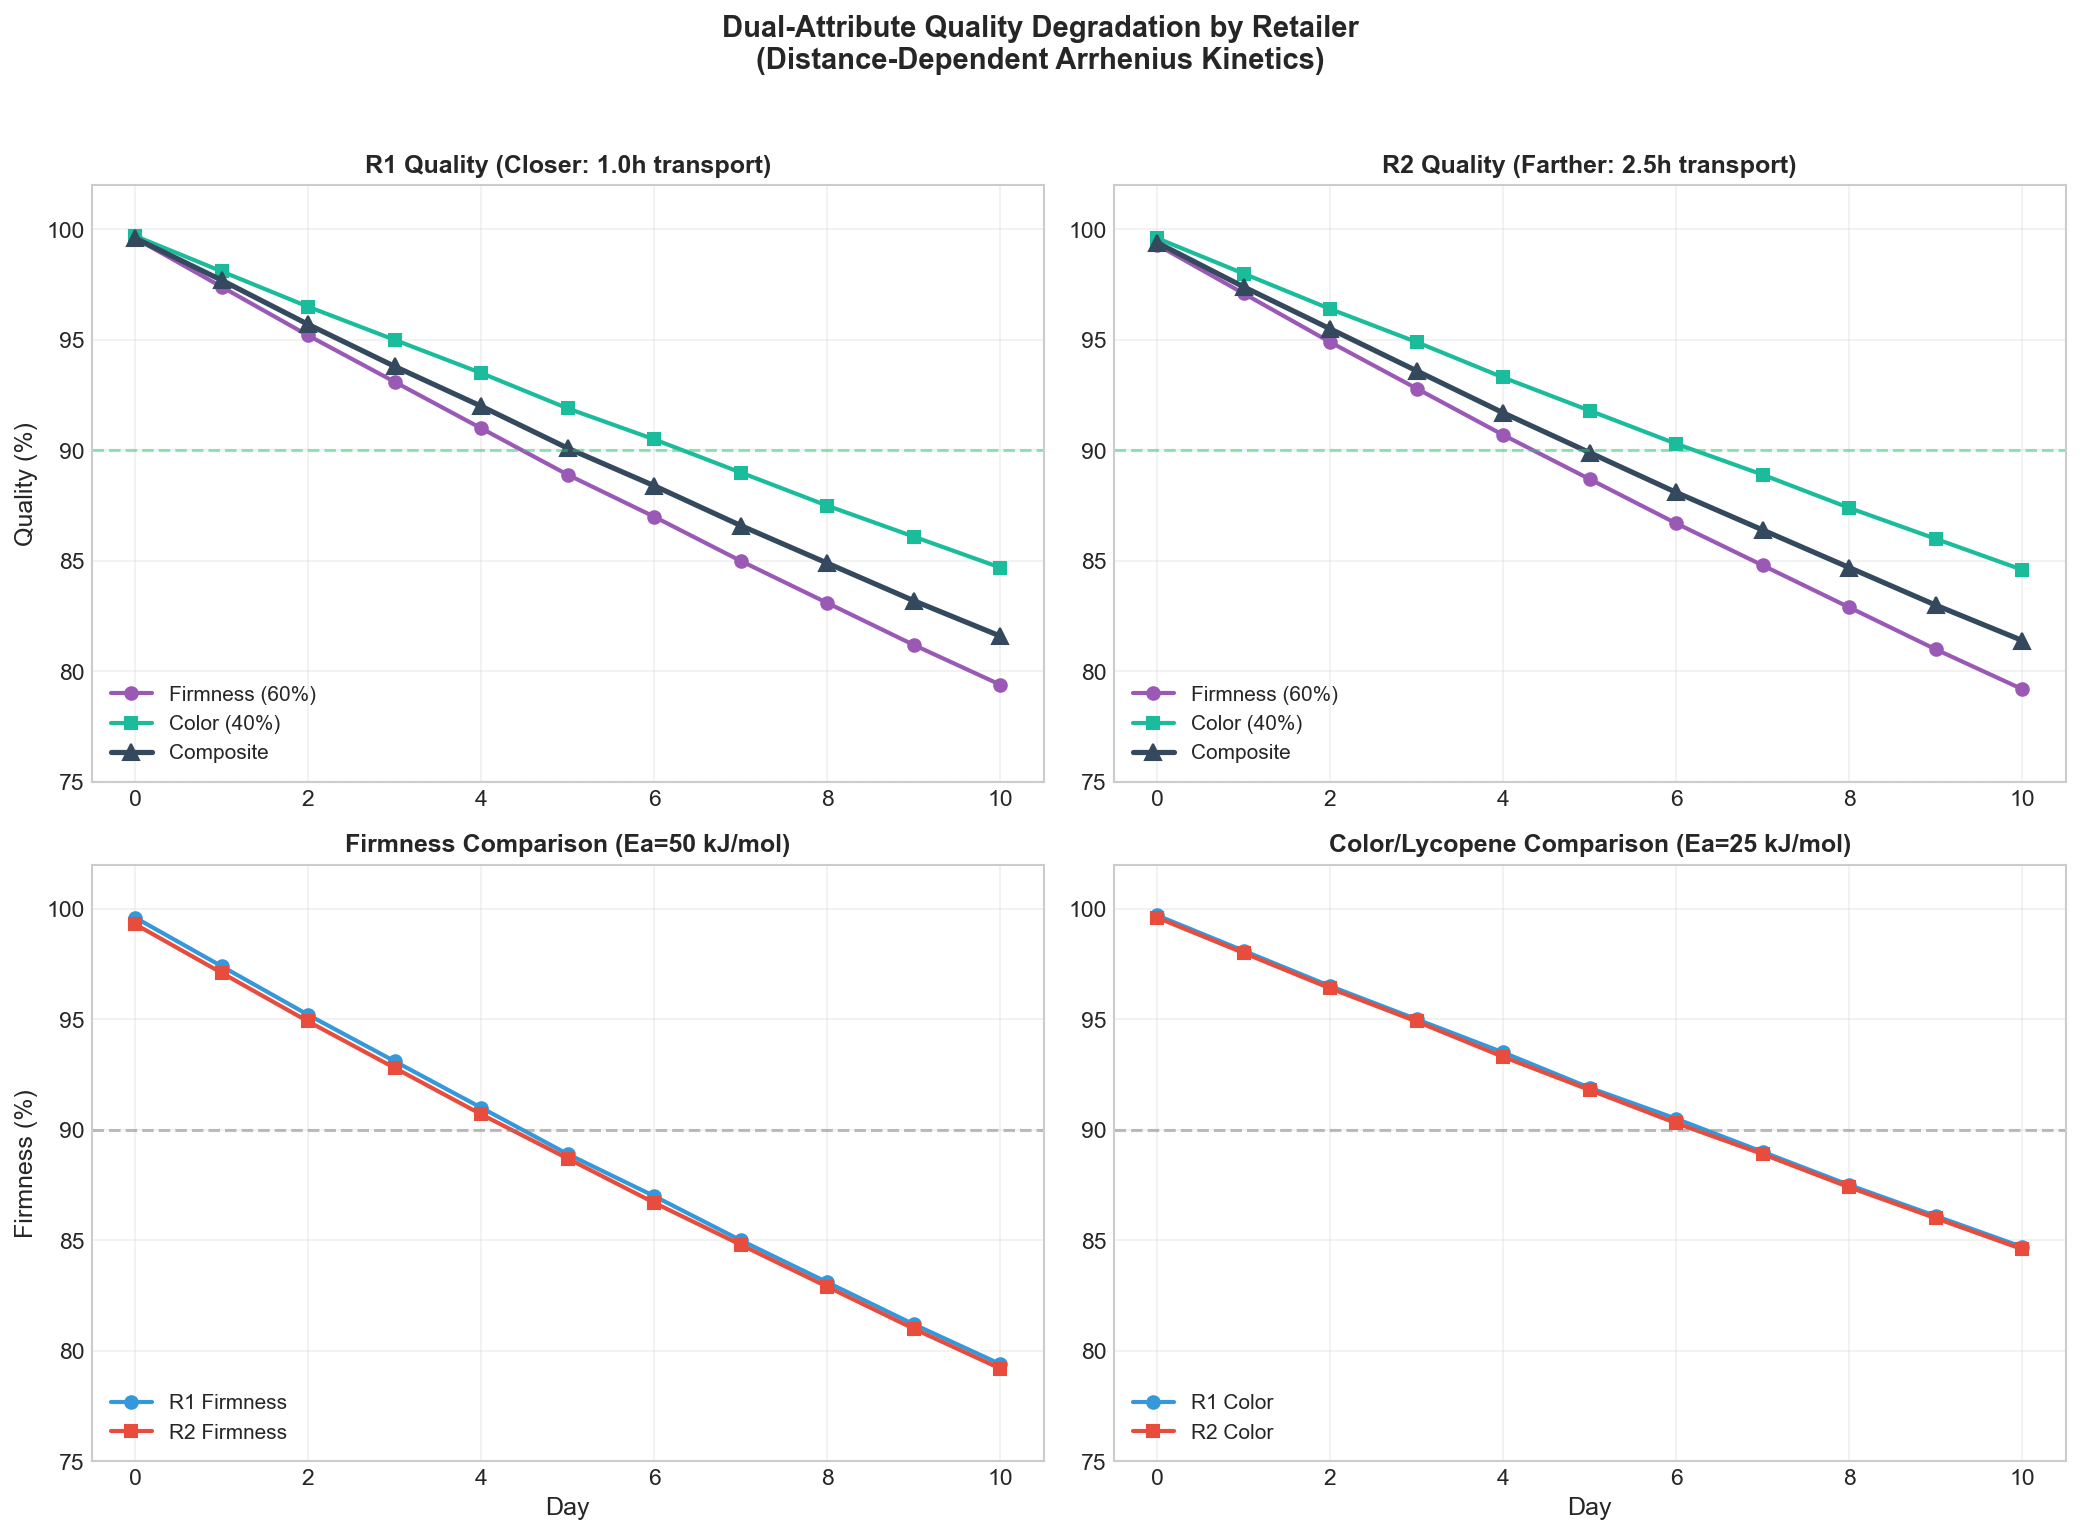

✅ Saved: pfscn_tier_transition_impact.png


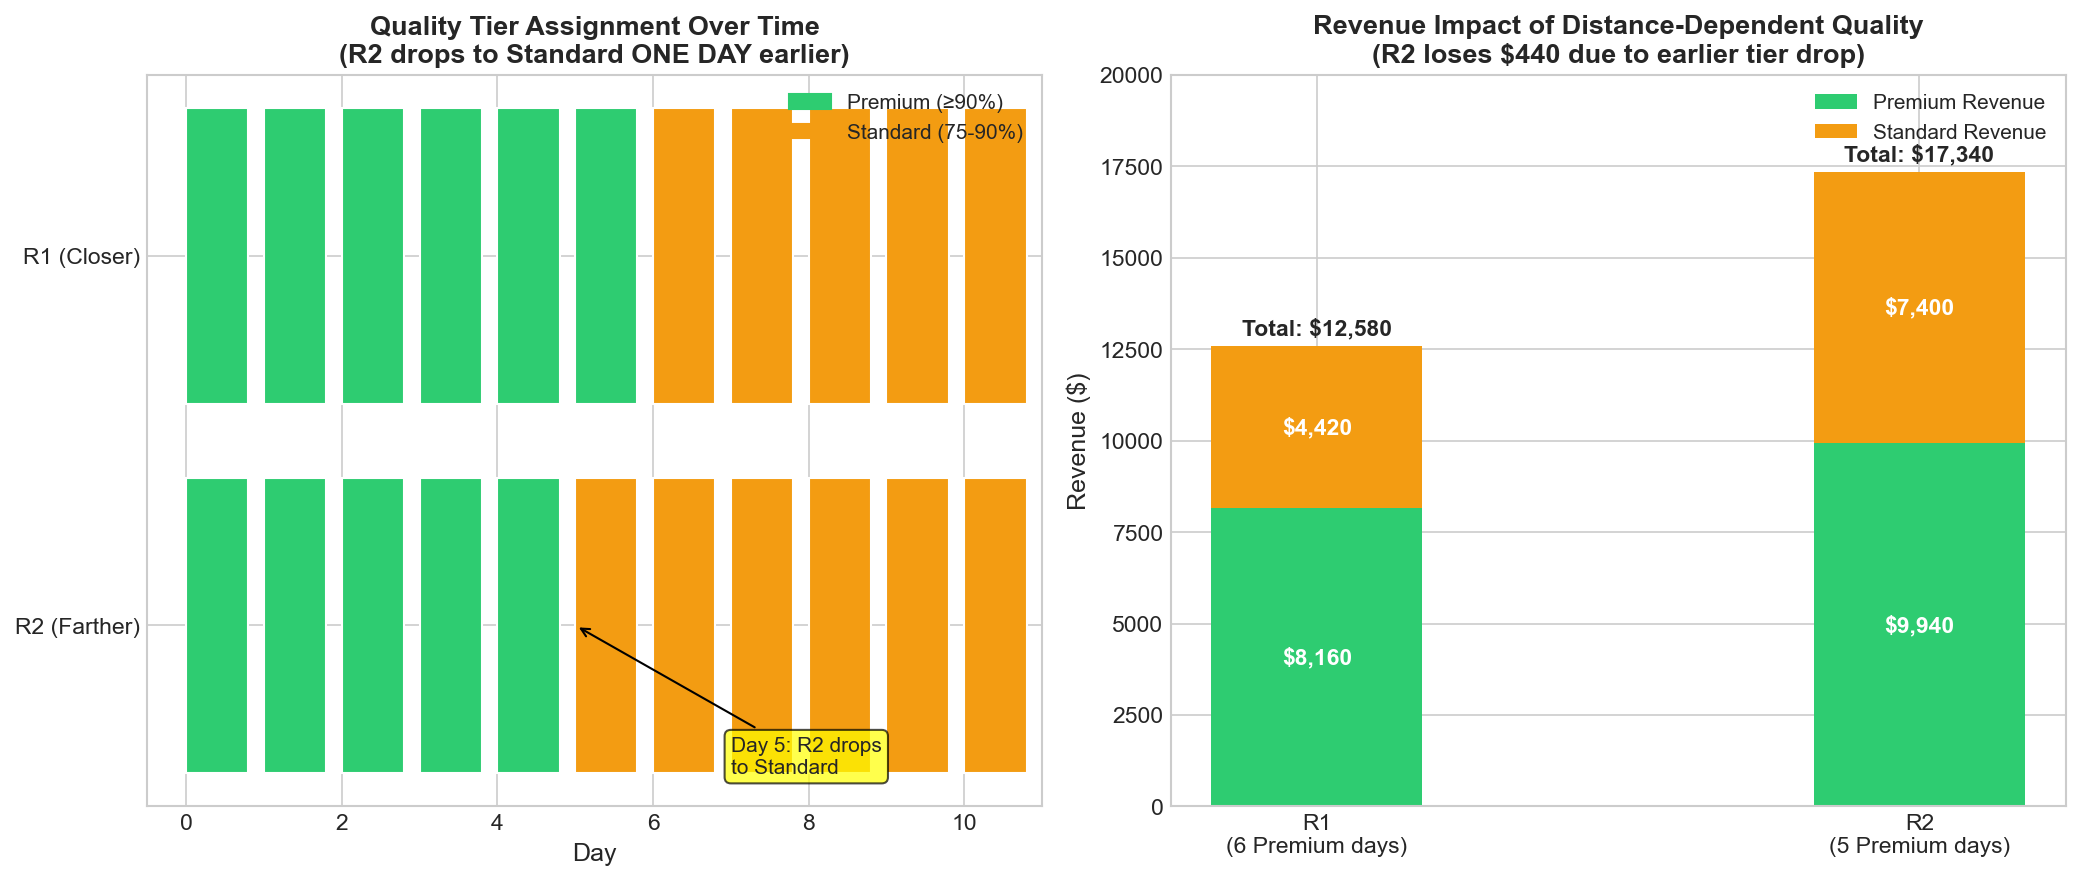

✅ Saved: pfscn_cost_breakdown_bar.png


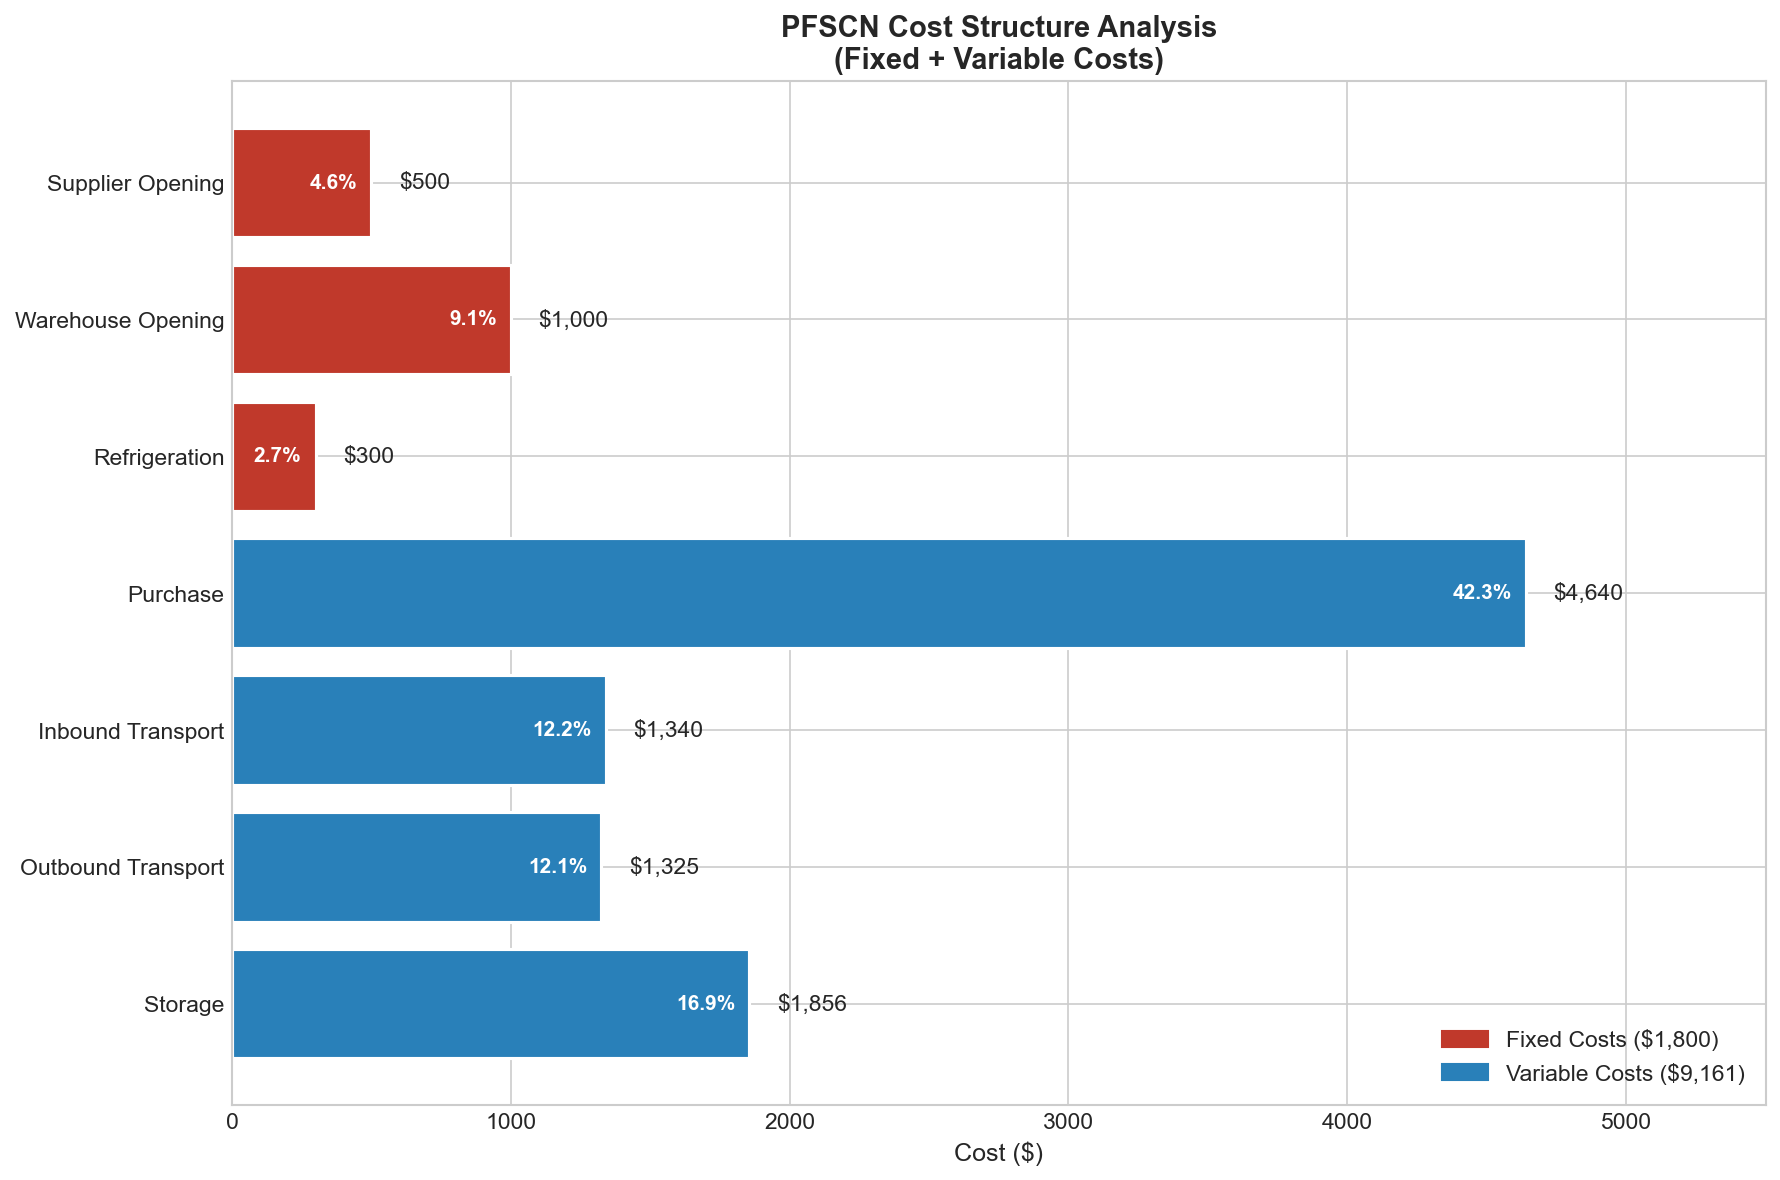

✅ Saved: pfscn_profit_waterfall.png


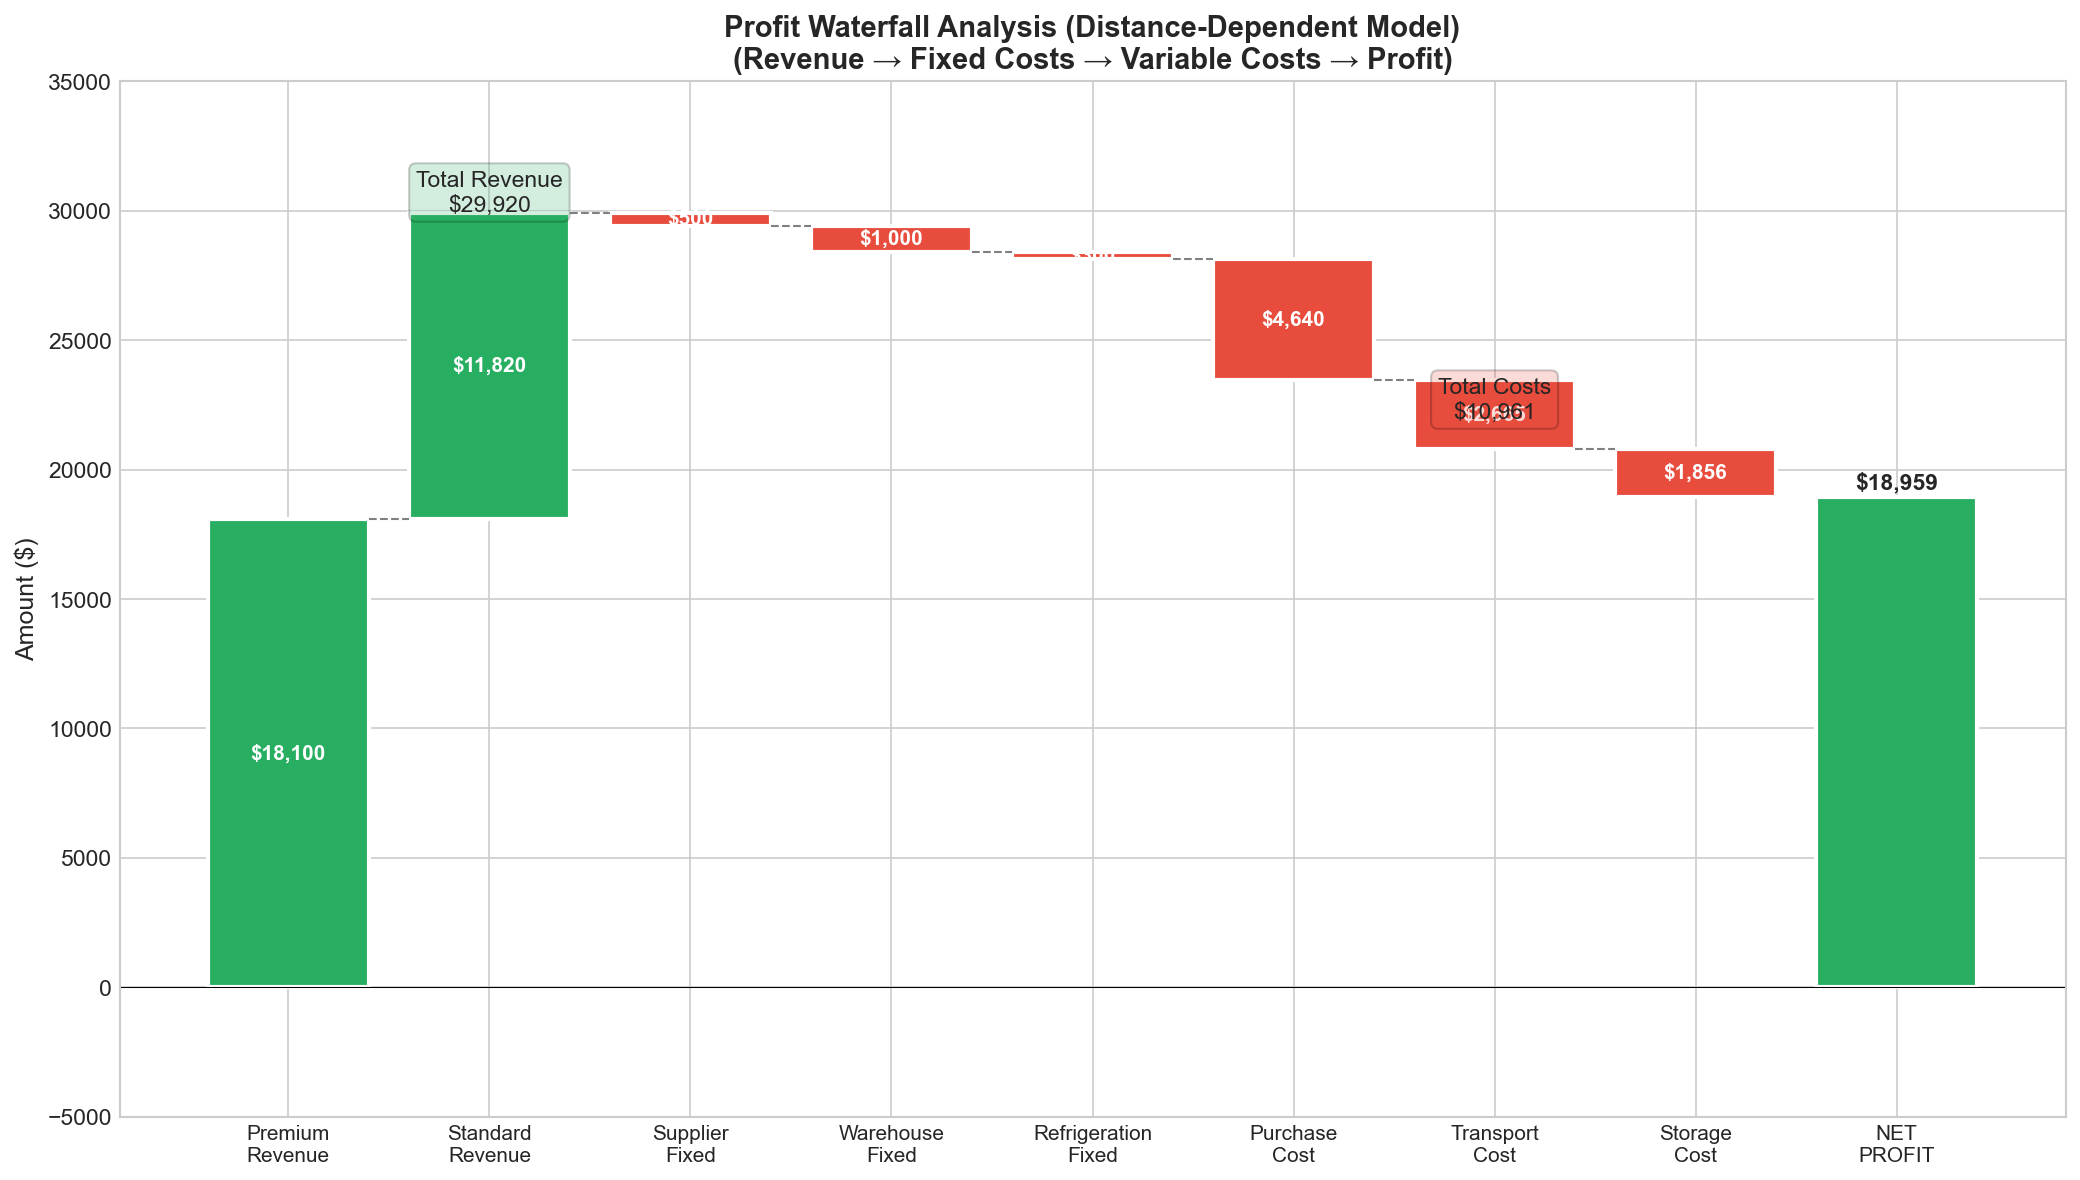

✅ Saved: pfscn_network_diagram.png


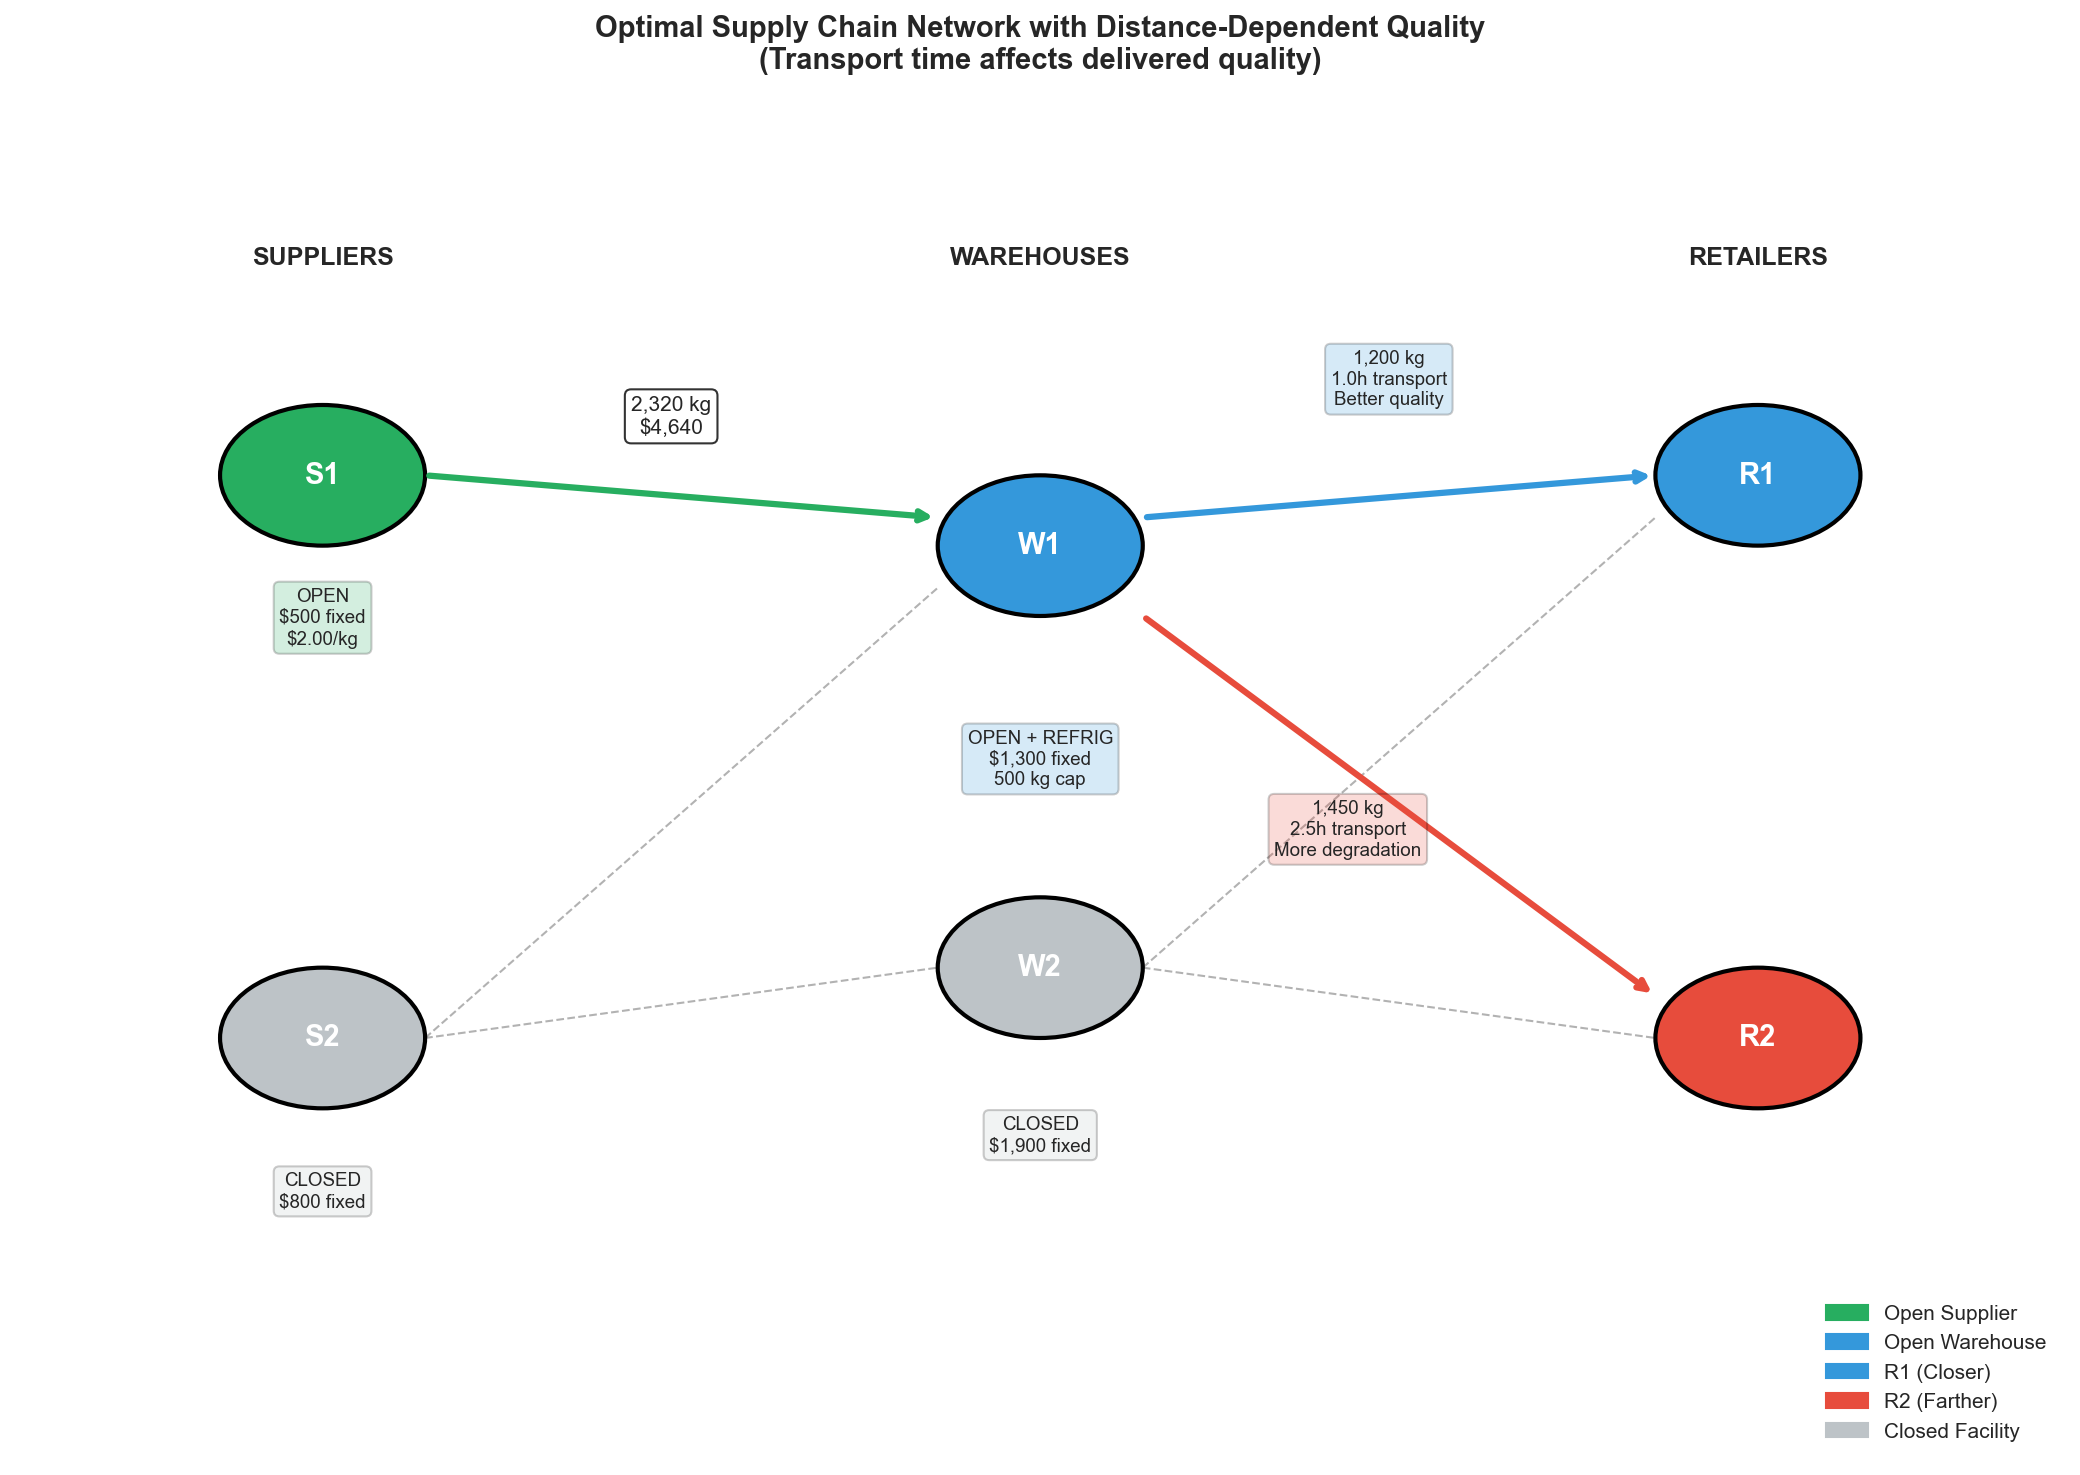

✅ Saved: pfscn_daily_flows.png


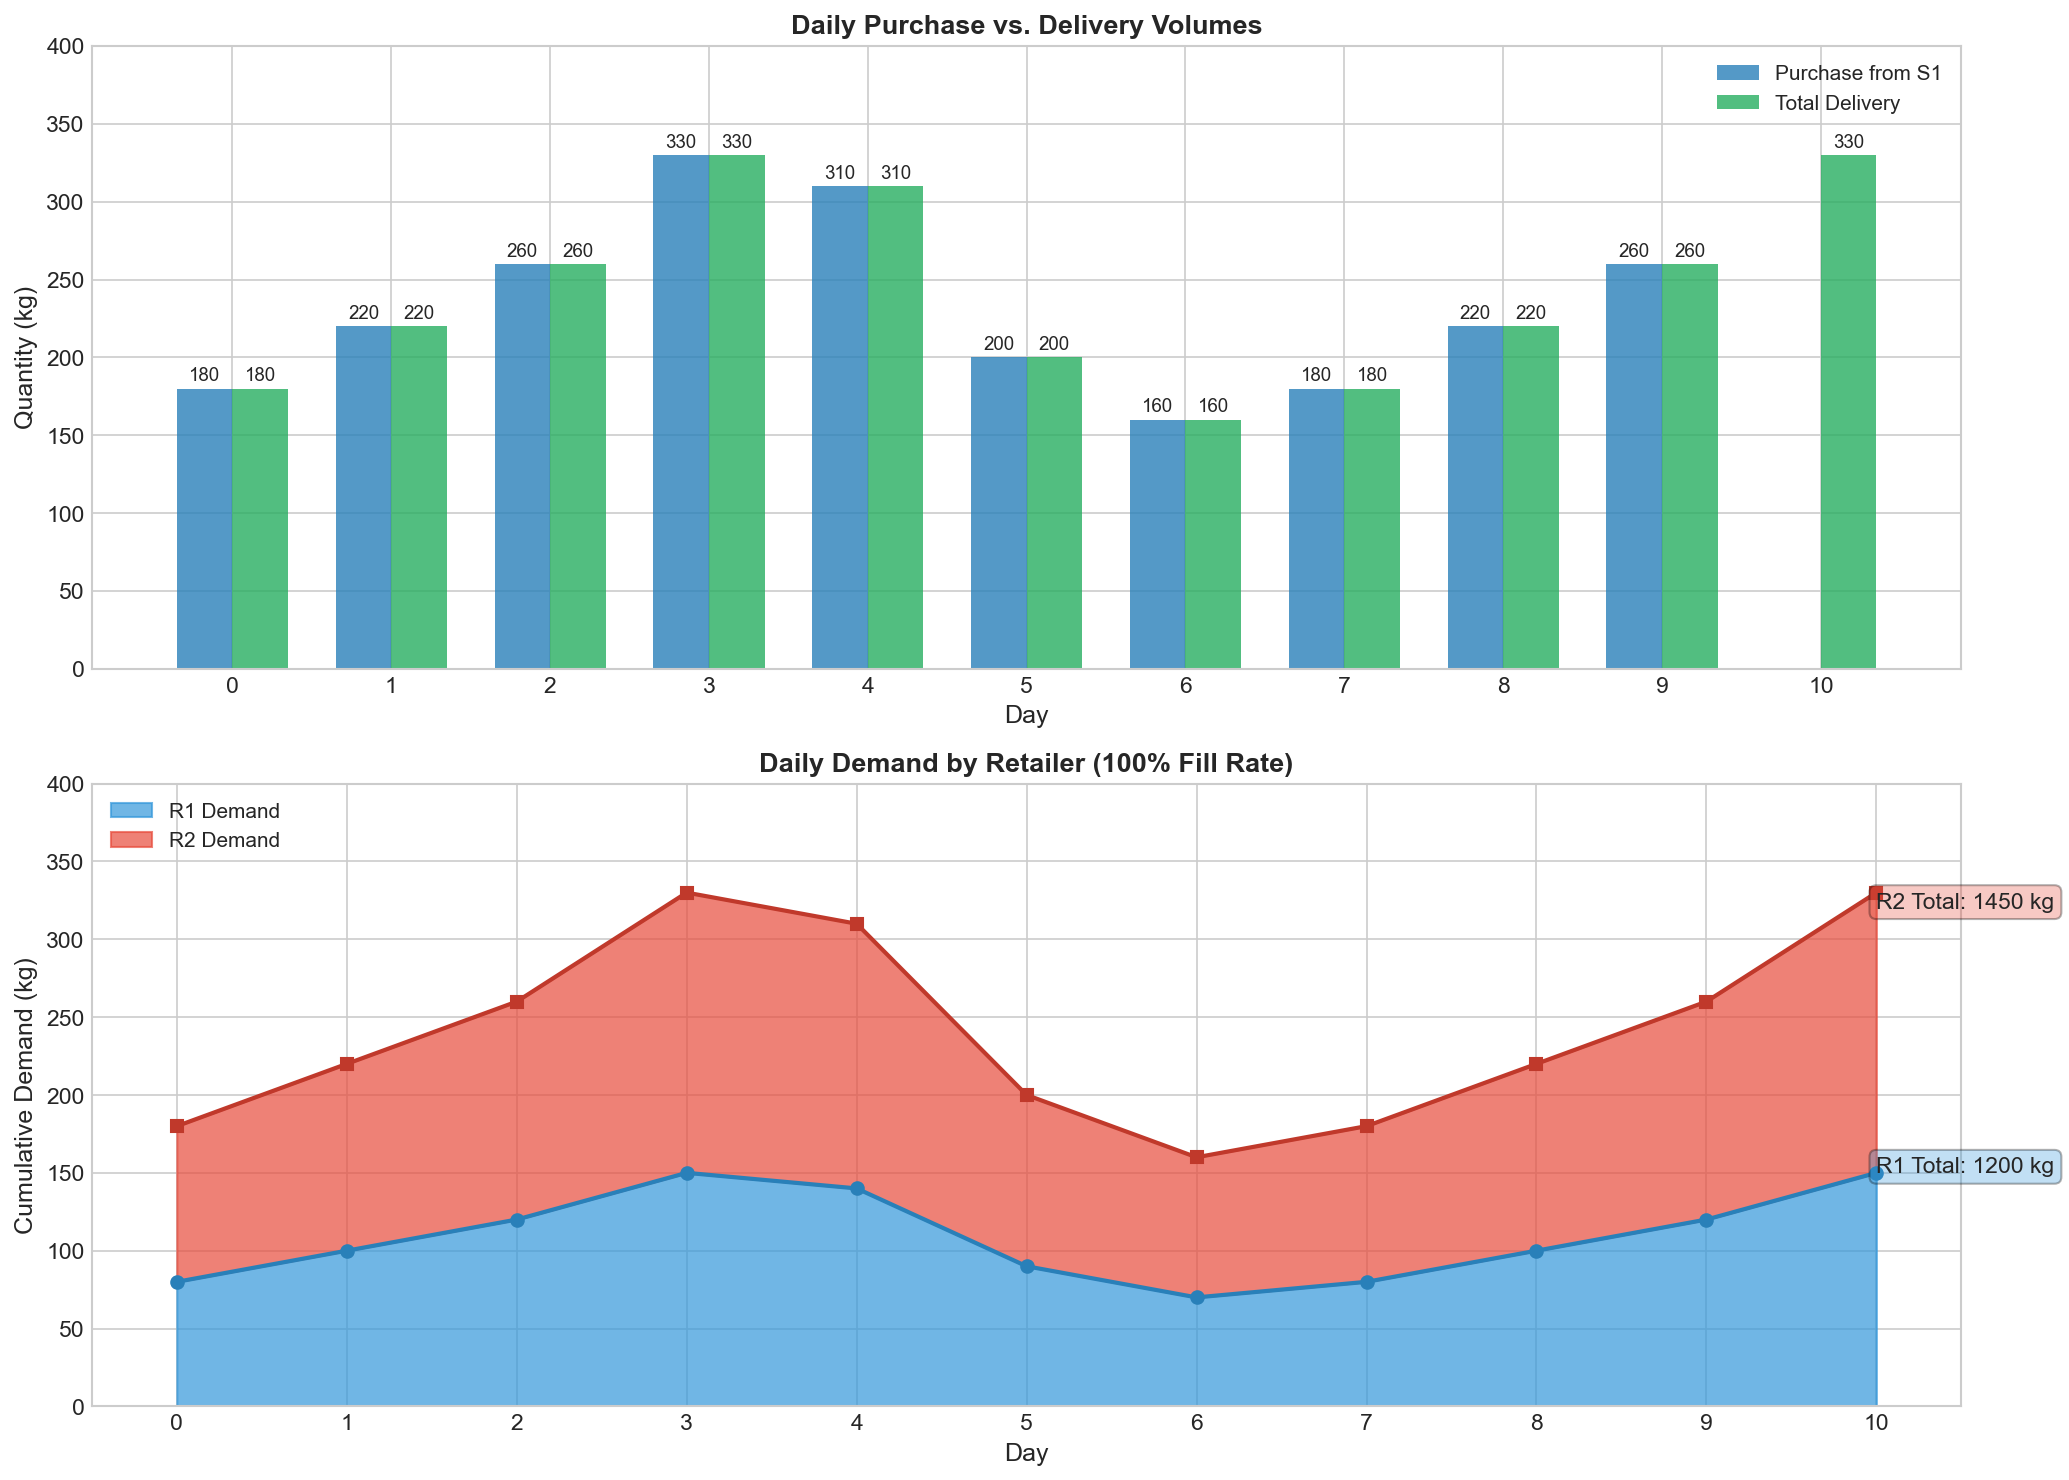


✅ Generated 7 visualizations!


In [3]:
#!/usr/bin/env python3
# ============================================================================
# PFSCN VISUALIZATION SUITE
# ============================================================================
# Comprehensive visualizations for the Perishable Food Supply Chain Network
# Dual-Attribute MILP Model with Facility Opening Costs
# NOW WITH DISTANCE-DEPENDENT QUALITY DEGRADATION
#
# Generates publication-ready figures for:
# - Quality degradation over time (R1 vs R2 - DIFFERENT!)
# - Cost breakdown analysis
# - Revenue by tier and retailer
# - Network flow diagrams
# - Transportation decisions
# - Comparative analysis
# ============================================================================

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import os

# Set style for publication-quality figures
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.dpi'] = 150

# Color palettes
COLORS = {
    'premium': '#2ecc71',      # Green
    'standard': '#f39c12',     # Orange
    'discount': '#e74c3c',     # Red
    'waste': '#95a5a6',        # Gray
    'refrigerated': '#3498db', # Blue
    'ambient': '#e67e22',      # Orange
    'firmness': '#9b59b6',     # Purple
    'color': '#1abc9c',        # Teal
    'composite': '#34495e',    # Dark gray
    'fixed': '#c0392b',        # Dark red
    'variable': '#2980b9',     # Blue
    'revenue': '#27ae60',      # Green
    'cost': '#e74c3c',         # Red
    'R1': '#3498db',           # Blue for R1
    'R2': '#e74c3c',           # Red for R2
}

# ============================================================================
# DATA FROM GUROBI RESULTS - NOW DISTANCE-DEPENDENT
# ============================================================================

# Time periods
days = list(range(11))

# DISTANCE-DEPENDENT Quality evolution data
# R1 is CLOSER (1.0h from W1) - receives FRESHER product
# R2 is FARTHER (2.5h from W1) - more degradation during transport
quality_data_R1 = {
    'firmness': [99.6, 97.4, 95.2, 93.1, 91.0, 88.9, 87.0, 85.0, 83.1, 81.2, 79.4],
    'color': [99.7, 98.1, 96.5, 95.0, 93.5, 91.9, 90.5, 89.0, 87.5, 86.1, 84.7],
    'composite': [99.6, 97.7, 95.7, 93.8, 92.0, 90.1, 88.4, 86.6, 84.9, 83.2, 81.6],
}

quality_data_R2 = {
    'firmness': [99.3, 97.1, 94.9, 92.8, 90.7, 88.7, 86.7, 84.8, 82.9, 81.0, 79.2],
    'color': [99.6, 98.0, 96.4, 94.9, 93.3, 91.8, 90.3, 88.9, 87.4, 86.0, 84.6],
    'composite': [99.4, 97.4, 95.5, 93.6, 91.7, 89.9, 88.1, 86.4, 84.7, 83.0, 81.4],
}

# Quality thresholds
thresholds = {
    'premium': 90,
    'standard': 75,
    'discount': 60,
}

# Transport times (hours)
transport_times = {
    'W1→R1': 1.0,
    'W1→R2': 2.5,
    'W2→R1': 2.0,
    'W2→R2': 1.2,
}

# Cost breakdown (from Gurobi output)
fixed_costs = {
    'Supplier Opening': 500,
    'Warehouse Opening': 1000,
    'Refrigeration Capability': 300,
}

variable_costs = {
    'Purchase': 4640,
    'Inbound Transport': 1340,
    'Outbound Transport': 1325,
    'Storage': 1856,
}

# Revenue by tier - NOW DIFFERENT DUE TO DISTANCE
revenue_data = {
    'R1': {'Premium': 8160, 'Standard': 4420, 'Discount': 0},
    'R2': {'Premium': 9940, 'Standard': 7400, 'Discount': 0},  # R2 loses 1 day of premium!
}

# Sales quantity by tier
sales_qty = {
    'R1': {'Premium': 680, 'Standard': 520, 'Discount': 0},
    'R2': {'Premium': 710, 'Standard': 740, 'Discount': 0},  # R2: less premium, more standard
}

# Daily flows
daily_purchase = [180, 220, 260, 330, 310, 200, 160, 180, 220, 260, 0]
daily_demand_r1 = [80, 100, 120, 150, 140, 90, 70, 80, 100, 120, 150]
daily_demand_r2 = [100, 120, 140, 180, 170, 110, 90, 100, 120, 140, 180]

# ============================================================================
# VISUALIZATION FUNCTIONS
# ============================================================================

def plot_quality_evolution_comparison():
    """Plot quality comparison between R1 and R2 showing distance effect"""
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    # Left: Composite quality comparison
    ax1 = axes[0]
    ax1.plot(days, quality_data_R1['composite'], 'o-', color=COLORS['R1'], 
             linewidth=2.5, markersize=8, label='R1 (1.0h from W1)')
    ax1.plot(days, quality_data_R2['composite'], 's-', color=COLORS['R2'], 
             linewidth=2.5, markersize=8, label='R2 (2.5h from W1)')
    
    # Add threshold lines
    ax1.axhline(y=90, color=COLORS['premium'], linestyle='--', linewidth=2, alpha=0.7)
    ax1.axhline(y=75, color=COLORS['standard'], linestyle='--', linewidth=2, alpha=0.7)
    
    # Shade quality zones
    ax1.axhspan(90, 100, alpha=0.15, color=COLORS['premium'])
    ax1.axhspan(75, 90, alpha=0.15, color=COLORS['standard'])
    ax1.axhspan(60, 75, alpha=0.15, color=COLORS['discount'])
    
    # Annotate the critical difference at Day 5
    ax1.annotate('R1: 90.1% (Premium)\nR2: 89.9% (Standard)', 
                xy=(5, 90), xytext=(6.5, 94),
                fontsize=10, ha='left',
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7),
                arrowprops=dict(arrowstyle='->', color='black'))
    
    ax1.axvline(x=5, color='gray', linestyle=':', linewidth=1.5, alpha=0.7)
    
    ax1.set_xlabel('Day', fontsize=12)
    ax1.set_ylabel('Composite Quality (%)', fontsize=12)
    ax1.set_title('Distance-Dependent Quality: R1 vs R2\n(R2 drops to Standard ONE DAY EARLIER)', 
                 fontsize=13, fontweight='bold')
    ax1.set_xlim(-0.5, 10.5)
    ax1.set_ylim(78, 102)
    ax1.set_xticks(days)
    ax1.legend(loc='lower left', framealpha=0.95)
    ax1.grid(True, alpha=0.3)
    
    # Add tier labels
    ax1.text(10.3, 95, 'Premium', fontsize=10, color=COLORS['premium'], fontweight='bold')
    ax1.text(10.3, 82, 'Standard', fontsize=10, color=COLORS['standard'], fontweight='bold')
    
    # Right: Quality difference (R1 - R2)
    ax2 = axes[1]
    quality_diff = [r1 - r2 for r1, r2 in zip(quality_data_R1['composite'], quality_data_R2['composite'])]
    
    bars = ax2.bar(days, quality_diff, color=COLORS['R1'], alpha=0.7, edgecolor='white', linewidth=1.5)
    
    # Add value labels
    for bar, val in zip(bars, quality_diff):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'+{val:.1f}%', ha='center', fontsize=9, fontweight='bold')
    
    ax2.axhline(y=0, color='black', linewidth=1)
    ax2.set_xlabel('Day', fontsize=12)
    ax2.set_ylabel('Quality Advantage R1 vs R2 (%)', fontsize=12)
    ax2.set_title('R1 Quality Advantage Due to Shorter Transport\n(1.0h vs 2.5h from Warehouse)', 
                 fontsize=13, fontweight='bold')
    ax2.set_xticks(days)
    ax2.set_ylim(0, 0.5)
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    return fig


def plot_quality_dual_attribute():
    """Plot firmness and color for both retailers"""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # R1 Firmness & Color
    axes[0, 0].plot(days, quality_data_R1['firmness'], 'o-', color=COLORS['firmness'], 
                    linewidth=2, markersize=6, label='Firmness (60%)')
    axes[0, 0].plot(days, quality_data_R1['color'], 's-', color=COLORS['color'], 
                    linewidth=2, markersize=6, label='Color (40%)')
    axes[0, 0].plot(days, quality_data_R1['composite'], '^-', color=COLORS['composite'], 
                    linewidth=2.5, markersize=8, label='Composite')
    axes[0, 0].axhline(y=90, color=COLORS['premium'], linestyle='--', alpha=0.5)
    axes[0, 0].axhline(y=75, color=COLORS['standard'], linestyle='--', alpha=0.5)
    axes[0, 0].set_title('R1 Quality (Closer: 1.0h transport)', fontsize=12, fontweight='bold')
    axes[0, 0].set_ylabel('Quality (%)')
    axes[0, 0].legend(loc='lower left')
    axes[0, 0].set_ylim(75, 102)
    axes[0, 0].grid(True, alpha=0.3)
    
    # R2 Firmness & Color
    axes[0, 1].plot(days, quality_data_R2['firmness'], 'o-', color=COLORS['firmness'], 
                    linewidth=2, markersize=6, label='Firmness (60%)')
    axes[0, 1].plot(days, quality_data_R2['color'], 's-', color=COLORS['color'], 
                    linewidth=2, markersize=6, label='Color (40%)')
    axes[0, 1].plot(days, quality_data_R2['composite'], '^-', color=COLORS['composite'], 
                    linewidth=2.5, markersize=8, label='Composite')
    axes[0, 1].axhline(y=90, color=COLORS['premium'], linestyle='--', alpha=0.5)
    axes[0, 1].axhline(y=75, color=COLORS['standard'], linestyle='--', alpha=0.5)
    axes[0, 1].set_title('R2 Quality (Farther: 2.5h transport)', fontsize=12, fontweight='bold')
    axes[0, 1].legend(loc='lower left')
    axes[0, 1].set_ylim(75, 102)
    axes[0, 1].grid(True, alpha=0.3)
    
    # Firmness comparison
    axes[1, 0].plot(days, quality_data_R1['firmness'], 'o-', color=COLORS['R1'], 
                    linewidth=2, markersize=6, label='R1 Firmness')
    axes[1, 0].plot(days, quality_data_R2['firmness'], 's-', color=COLORS['R2'], 
                    linewidth=2, markersize=6, label='R2 Firmness')
    axes[1, 0].axhline(y=90, color='gray', linestyle='--', alpha=0.5)
    axes[1, 0].set_title('Firmness Comparison (Ea=50 kJ/mol)', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Day')
    axes[1, 0].set_ylabel('Firmness (%)')
    axes[1, 0].legend(loc='lower left')
    axes[1, 0].set_ylim(75, 102)
    axes[1, 0].grid(True, alpha=0.3)
    
    # Color comparison
    axes[1, 1].plot(days, quality_data_R1['color'], 'o-', color=COLORS['R1'], 
                    linewidth=2, markersize=6, label='R1 Color')
    axes[1, 1].plot(days, quality_data_R2['color'], 's-', color=COLORS['R2'], 
                    linewidth=2, markersize=6, label='R2 Color')
    axes[1, 1].axhline(y=90, color='gray', linestyle='--', alpha=0.5)
    axes[1, 1].set_title('Color/Lycopene Comparison (Ea=25 kJ/mol)', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Day')
    axes[1, 1].legend(loc='lower left')
    axes[1, 1].set_ylim(75, 102)
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.suptitle('Dual-Attribute Quality Degradation by Retailer\n(Distance-Dependent Arrhenius Kinetics)', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    return fig


def plot_tier_transition_impact():
    """Visualize the financial impact of tier transitions"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Left: Tier assignment over time
    ax1 = axes[0]
    
    # R1 tiers
    r1_premium_days = [0, 1, 2, 3, 4, 5]
    r1_standard_days = [6, 7, 8, 9, 10]
    
    # R2 tiers (drops one day earlier!)
    r2_premium_days = [0, 1, 2, 3, 4]
    r2_standard_days = [5, 6, 7, 8, 9, 10]
    
    # Create stacked visualization
    y_positions = [1.5, 0.5]
    
    for day in days:
        # R1 (top row)
        color = COLORS['premium'] if day in r1_premium_days else COLORS['standard']
        ax1.barh(1.5, 0.8, left=day, color=color, edgecolor='white', linewidth=1)
        
        # R2 (bottom row)
        color = COLORS['premium'] if day in r2_premium_days else COLORS['standard']
        ax1.barh(0.5, 0.8, left=day, color=color, edgecolor='white', linewidth=1)
    
    ax1.set_yticks([0.5, 1.5])
    ax1.set_yticklabels(['R2 (Farther)', 'R1 (Closer)'])
    ax1.set_xlabel('Day', fontsize=12)
    ax1.set_title('Quality Tier Assignment Over Time\n(R2 drops to Standard ONE DAY earlier)', 
                 fontsize=13, fontweight='bold')
    ax1.set_xlim(-0.5, 11)
    
    # Add legend
    premium_patch = mpatches.Patch(color=COLORS['premium'], label='Premium (≥90%)')
    standard_patch = mpatches.Patch(color=COLORS['standard'], label='Standard (75-90%)')
    ax1.legend(handles=[premium_patch, standard_patch], loc='upper right')
    
    # Add annotation for Day 5
    ax1.annotate('Day 5: R2 drops\nto Standard', xy=(5, 0.5), xytext=(7, 0.1),
                fontsize=10, bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7),
                arrowprops=dict(arrowstyle='->', color='black'))
    
    # Right: Revenue impact
    ax2 = axes[1]
    
    categories = ['R1\n(6 Premium days)', 'R2\n(5 Premium days)']
    premium_rev = [revenue_data['R1']['Premium'], revenue_data['R2']['Premium']]
    standard_rev = [revenue_data['R1']['Standard'], revenue_data['R2']['Standard']]
    
    x = np.arange(len(categories))
    width = 0.35
    
    bars1 = ax2.bar(x, premium_rev, width, label='Premium Revenue', color=COLORS['premium'])
    bars2 = ax2.bar(x, standard_rev, width, bottom=premium_rev, label='Standard Revenue', color=COLORS['standard'])
    
    # Add value labels
    for i, (p, s) in enumerate(zip(premium_rev, standard_rev)):
        ax2.text(i, p/2, f'${p:,}', ha='center', va='center', fontsize=11, color='white', fontweight='bold')
        ax2.text(i, p + s/2, f'${s:,}', ha='center', va='center', fontsize=11, color='white', fontweight='bold')
        ax2.text(i, p + s + 300, f'Total: ${p+s:,}', ha='center', fontsize=11, fontweight='bold')
    
    ax2.set_xticks(x)
    ax2.set_xticklabels(categories)
    ax2.set_ylabel('Revenue ($)', fontsize=12)
    ax2.set_title('Revenue Impact of Distance-Dependent Quality\n(R2 loses $440 due to earlier tier drop)', 
                 fontsize=13, fontweight='bold')
    ax2.legend(loc='upper right')
    ax2.set_ylim(0, 20000)
    
    plt.tight_layout()
    return fig


def plot_cost_breakdown_bar():
    """Create horizontal bar chart of cost breakdown"""
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Prepare data
    categories = ['Supplier Opening', 'Warehouse Opening', 'Refrigeration',
                  'Purchase', 'Inbound Transport', 'Outbound Transport', 'Storage']
    values = [500, 1000, 300, 4640, 1340, 1325, 1856]
    colors = [COLORS['fixed']] * 3 + [COLORS['variable']] * 4
    
    # Create horizontal bars
    y_pos = np.arange(len(categories))
    bars = ax.barh(y_pos, values, color=colors, edgecolor='white', linewidth=1.5)
    
    # Add value labels
    for bar, val in zip(bars, values):
        width = bar.get_width()
        ax.text(width + 100, bar.get_y() + bar.get_height()/2,
                f'${val:,.0f}', va='center', fontsize=11)
    
    # Add percentage labels
    total = sum(values)
    for bar, val in zip(bars, values):
        pct = val / total * 100
        ax.text(bar.get_width() - 50, bar.get_y() + bar.get_height()/2,
                f'{pct:.1f}%', va='center', ha='right', fontsize=10, color='white', fontweight='bold')
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(categories)
    ax.set_xlabel('Cost ($)', fontsize=12)
    ax.set_title('PFSCN Cost Structure Analysis\n(Fixed + Variable Costs)', fontsize=14, fontweight='bold')
    ax.set_xlim(0, 5500)
    
    # Add legend
    fixed_patch = mpatches.Patch(color=COLORS['fixed'], label=f'Fixed Costs (${sum(values[:3]):,})')
    variable_patch = mpatches.Patch(color=COLORS['variable'], label=f'Variable Costs (${sum(values[3:]):,})')
    ax.legend(handles=[fixed_patch, variable_patch], loc='lower right', fontsize=11)
    
    ax.invert_yaxis()
    plt.tight_layout()
    return fig


def plot_profit_waterfall():
    """Create waterfall chart showing profit buildup"""
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Data for waterfall (updated with distance-dependent results)
    categories = ['Premium\nRevenue', 'Standard\nRevenue', 'Supplier\nFixed', 'Warehouse\nFixed', 
                  'Refrigeration\nFixed', 'Purchase\nCost', 'Transport\nCost', 'Storage\nCost', 'NET\nPROFIT']
    values = [18100, 11820, -500, -1000, -300, -4640, -2665, -1856, 0]
    
    # Calculate cumulative
    cumulative = [0]
    for i, v in enumerate(values[:-1]):
        cumulative.append(cumulative[-1] + v)
    values[-1] = cumulative[-1]
    
    # Colors
    colors = []
    for i, v in enumerate(values):
        if i == len(values) - 1:
            colors.append('#27ae60' if v > 0 else '#e74c3c')
        elif v >= 0:
            colors.append('#27ae60')
        else:
            colors.append('#e74c3c')
    
    x = np.arange(len(categories))
    
    for i, (cat, val) in enumerate(zip(categories, values)):
        if i == len(values) - 1:
            ax.bar(i, val, color=colors[i], edgecolor='white', linewidth=2)
            ax.text(i, val + 300, f'${val:,}', ha='center', fontsize=11, fontweight='bold')
        else:
            bottom = cumulative[i]
            ax.bar(i, val, bottom=bottom, color=colors[i], edgecolor='white', linewidth=2)
            label_y = bottom + val/2 if val > 0 else bottom + val/2
            ax.text(i, label_y, f'${abs(val):,}', ha='center', va='center', 
                   fontsize=10, color='white', fontweight='bold')
    
    # Add connecting lines
    for i in range(len(categories) - 2):
        ax.plot([i + 0.4, i + 0.6], [cumulative[i+1], cumulative[i+1]], 
               color='gray', linestyle='--', linewidth=1)
    
    ax.set_xticks(x)
    ax.set_xticklabels(categories, fontsize=10)
    ax.set_ylabel('Amount ($)', fontsize=12)
    ax.set_title('Profit Waterfall Analysis (Distance-Dependent Model)\n(Revenue → Fixed Costs → Variable Costs → Profit)', 
                 fontsize=14, fontweight='bold')
    ax.axhline(y=0, color='black', linewidth=0.5)
    ax.set_ylim(-5000, 35000)
    
    # Add annotations
    ax.annotate('Total Revenue\n$29,920', xy=(1, 30000), fontsize=11, ha='center',
               bbox=dict(boxstyle='round', facecolor='#27ae60', alpha=0.2))
    ax.annotate('Total Costs\n$10,961', xy=(6, 22000), fontsize=11, ha='center',
               bbox=dict(boxstyle='round', facecolor='#e74c3c', alpha=0.2))
    
    plt.tight_layout()
    return fig


def plot_network_diagram():
    """Create supply chain network diagram with distance annotations"""
    fig, ax = plt.subplots(figsize=(14, 10))
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.axis('off')
    
    # Node positions
    nodes = {
        'S1': (1.5, 7), 'S2': (1.5, 3),
        'W1': (5, 6.5), 'W2': (5, 3.5),
        'R1': (8.5, 7), 'R2': (8.5, 3),
    }
    
    # Node colors
    node_colors = {
        'S1': '#27ae60', 'S2': '#bdc3c7',
        'W1': '#3498db', 'W2': '#bdc3c7',
        'R1': COLORS['R1'], 'R2': COLORS['R2'],
    }
    
    for node, (x, y) in nodes.items():
        circle = plt.Circle((x, y), 0.5, color=node_colors[node], ec='black', linewidth=2)
        ax.add_patch(circle)
        ax.text(x, y, node, ha='center', va='center', fontsize=14, fontweight='bold', color='white')
    
    # Draw active flow arrows
    ax.annotate('', xy=(4.5, 6.7), xytext=(2, 7),
                arrowprops=dict(arrowstyle='->', color='#27ae60', lw=3))
    ax.text(3.2, 7.3, '2,320 kg\n$4,640', ha='center', fontsize=10, 
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # W1 → R1 (SHORTER - 1.0h)
    ax.annotate('', xy=(8, 7), xytext=(5.5, 6.7),
                arrowprops=dict(arrowstyle='->', color=COLORS['R1'], lw=3))
    ax.text(6.7, 7.5, '1,200 kg\n1.0h transport\nBetter quality', ha='center', fontsize=9,
           bbox=dict(boxstyle='round', facecolor=COLORS['R1'], alpha=0.2))
    
    # W1 → R2 (LONGER - 2.5h)
    ax.annotate('', xy=(8, 3.3), xytext=(5.5, 6),
                arrowprops=dict(arrowstyle='->', color=COLORS['R2'], lw=3))
    ax.text(6.5, 4.3, '1,450 kg\n2.5h transport\nMore degradation', ha='center', fontsize=9,
           bbox=dict(boxstyle='round', facecolor=COLORS['R2'], alpha=0.2))
    
    # Draw inactive paths
    ax.plot([2, 4.5], [3, 3.5], 'k--', alpha=0.3, linewidth=1)
    ax.plot([2, 4.5], [3, 6.2], 'k--', alpha=0.3, linewidth=1)
    ax.plot([5.5, 8], [3.5, 3], 'k--', alpha=0.3, linewidth=1)
    ax.plot([5.5, 8], [3.5, 6.7], 'k--', alpha=0.3, linewidth=1)
    
    # Labels
    ax.text(1.5, 8.5, 'SUPPLIERS', ha='center', fontsize=12, fontweight='bold')
    ax.text(5, 8.5, 'WAREHOUSES', ha='center', fontsize=12, fontweight='bold')
    ax.text(8.5, 8.5, 'RETAILERS', ha='center', fontsize=12, fontweight='bold')
    
    # Node details
    ax.text(1.5, 5.8, 'OPEN\n$500 fixed\n$2.00/kg', ha='center', fontsize=9,
           bbox=dict(boxstyle='round', facecolor='#27ae60', alpha=0.2))
    ax.text(1.5, 1.8, 'CLOSED\n$800 fixed', ha='center', fontsize=9,
           bbox=dict(boxstyle='round', facecolor='#bdc3c7', alpha=0.2))
    ax.text(5, 4.8, 'OPEN + REFRIG\n$1,300 fixed\n500 kg cap', ha='center', fontsize=9,
           bbox=dict(boxstyle='round', facecolor='#3498db', alpha=0.2))
    ax.text(5, 2.2, 'CLOSED\n$1,900 fixed', ha='center', fontsize=9,
           bbox=dict(boxstyle='round', facecolor='#bdc3c7', alpha=0.2))
    
    ax.set_title('Optimal Supply Chain Network with Distance-Dependent Quality\n(Transport time affects delivered quality)', 
                 fontsize=14, fontweight='bold', y=0.98)
    
    legend_elements = [
        mpatches.Patch(color='#27ae60', label='Open Supplier'),
        mpatches.Patch(color='#3498db', label='Open Warehouse'),
        mpatches.Patch(color=COLORS['R1'], label='R1 (Closer)'),
        mpatches.Patch(color=COLORS['R2'], label='R2 (Farther)'),
        mpatches.Patch(color='#bdc3c7', label='Closed Facility'),
    ]
    ax.legend(handles=legend_elements, loc='lower right', fontsize=10)
    
    plt.tight_layout()
    return fig


def plot_daily_flows():
    """Plot daily product flows"""
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    total_delivery = [r1 + r2 for r1, r2 in zip(daily_demand_r1, daily_demand_r2)]
    
    x = np.arange(len(days))
    width = 0.35
    
    bars1 = axes[0].bar(x - width/2, daily_purchase, width, label='Purchase from S1', 
                        color=COLORS['variable'], alpha=0.8)
    bars2 = axes[0].bar(x + width/2, total_delivery, width, label='Total Delivery',
                        color=COLORS['revenue'], alpha=0.8)
    
    for bar in bars1:
        if bar.get_height() > 0:
            axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                        f'{int(bar.get_height())}', ha='center', fontsize=9)
    for bar in bars2:
        axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                    f'{int(bar.get_height())}', ha='center', fontsize=9)
    
    axes[0].set_xlabel('Day', fontsize=12)
    axes[0].set_ylabel('Quantity (kg)', fontsize=12)
    axes[0].set_title('Daily Purchase vs. Delivery Volumes', fontsize=13, fontweight='bold')
    axes[0].set_xticks(x)
    axes[0].legend(loc='upper right')
    axes[0].set_ylim(0, 400)
    
    # Bottom: Demand by retailer
    axes[1].fill_between(days, 0, daily_demand_r1, alpha=0.7, color=COLORS['R1'], label='R1 Demand')
    axes[1].fill_between(days, daily_demand_r1, total_delivery, alpha=0.7, color=COLORS['R2'], label='R2 Demand')
    axes[1].plot(days, daily_demand_r1, 'o-', color='#2980b9', linewidth=2, markersize=6)
    axes[1].plot(days, total_delivery, 's-', color='#c0392b', linewidth=2, markersize=6)
    
    axes[1].annotate(f'R1 Total: {sum(daily_demand_r1)} kg', xy=(10, 150), fontsize=11, 
                     bbox=dict(boxstyle='round', facecolor=COLORS['R1'], alpha=0.3))
    axes[1].annotate(f'R2 Total: {sum(daily_demand_r2)} kg', xy=(10, 320), fontsize=11,
                     bbox=dict(boxstyle='round', facecolor=COLORS['R2'], alpha=0.3))
    
    axes[1].set_xlabel('Day', fontsize=12)
    axes[1].set_ylabel('Cumulative Demand (kg)', fontsize=12)
    axes[1].set_title('Daily Demand by Retailer (100% Fill Rate)', fontsize=13, fontweight='bold')
    axes[1].set_xticks(days)
    axes[1].legend(loc='upper left')
    axes[1].set_ylim(0, 400)
    
    plt.tight_layout()
    return fig


def save_all_figures(output_dir='/mnt/user-data/outputs', show=False):
    """Generate and save all figures"""
    
    os.makedirs(output_dir, exist_ok=True)
    
    figures = {
        'pfscn_quality_comparison.png': plot_quality_evolution_comparison,
        'pfscn_quality_dual_attribute.png': plot_quality_dual_attribute,
        'pfscn_tier_transition_impact.png': plot_tier_transition_impact,
        'pfscn_cost_breakdown_bar.png': plot_cost_breakdown_bar,
        'pfscn_profit_waterfall.png': plot_profit_waterfall,
        'pfscn_network_diagram.png': plot_network_diagram,
        'pfscn_daily_flows.png': plot_daily_flows,
    }
    
    saved_files = []
    for filename, plot_func in figures.items():
        filepath = os.path.join(output_dir, filename)
        fig = plot_func()
        fig.savefig(filepath, dpi=150, bbox_inches='tight', facecolor='white')
        saved_files.append(filepath)
        print(f"✅ Saved: {filename}")
        
        if show:
            plt.show()
        else:
            plt.close(fig)
    
    return saved_files


# ============================================================================
# MAIN EXECUTION
# ============================================================================
if __name__ == "__main__":
    print("\n" + "=" * 70)
    print("📊 PFSCN VISUALIZATION SUITE (Distance-Dependent)")
    print("=" * 70)
    print("Generating publication-ready figures...\n")
    
    # Set show=True to display figures interactively
    saved_files = save_all_figures(show=True)
    
    print("\n" + "=" * 70)
    print(f"✅ Generated {len(saved_files)} visualizations!")
    print("=" * 70)